### Install Libs

In [18]:
! pip install dataprep
! pip install nltk
! pip install lightgbm
! pip install xgboost
! pip install --upgrade pip
! pip install -U scikit-learn seaborn catboost
! pip install CatBoostClassifier
! pip install catboost

### Imports Libs

In [189]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score

from dataprep.eda import create_report # Pacote de analise exploratoria
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Alterar configuração Default do Pandas para visualizar mais linhas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100 

# Evita que o pandas apresente valores em notação científica e com duas casas deciais
pd.set_option('display.float_format', lambda x: '%.2f' % x)

plt.style.use('fivethirtyeight')
%matplotlib inline
pd.set_option('display.max_columns', 32)

# Funções Para Auxiliar a Visualização de Dados

In [190]:
def show_missing(df):
    """Return a Pandas dataframe describing the contents of a source dataframe including missing values."""
    
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    pct_missing = []
    is_null = []
    pct_is_null = []
    
    
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        pct_missing.append(round((df[item].isna().sum() / len(df[item])) * 100, 2))
        is_null.append(df[item].isnull().sum())
        pct_is_null.append(round((df[item].isnull().sum() / len(df[item])) * 100, 2))

    output = pd.DataFrame({
        'variable': variables, 
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing': missing, 
        '%_missing': pct_missing,
        'is_null': is_null, 
        '%is_null':pct_is_null
    })    
        
    return output

# Funções Para Gerar Gráficos no Seborn
#plt.style.use("seaborn-v0_8")

def boxplot_seaborn(df, grid_plot_rows, grid_plot_columns):
    names = df.select_dtypes(include='number').columns
    f, axes = plt.subplots(grid_plot_rows, grid_plot_columns)
    f.set_size_inches(16, 20)  # Aumenta o tamanho da área do plot

    font_size_title = 18  # Tamanho da fonte do título
    font_size_ticklabels = 14  # Tamanho da fonte dos tick labels

    y = 0

    for name in names:
        i, j = divmod(y, grid_plot_columns)
        ax = sns.boxplot(x='cancellation', y=df[name], ax=axes[i, j], hue='cancellation')
        ax.set_title(name, fontsize=font_size_title)  # Aumenta o tamanho da fonte do título
        ax.tick_params(axis='both', labelsize=font_size_ticklabels)  # Aumenta o tamanho da fonte dos tick labels

        y += 1

    plt.show()
    

def histogram_seaborn(df,font_size):
    names = df.select_dtypes(include='number').columns
    f, axes = plt.subplots(nrows=len(names), figsize=(40, 80))
    f.set_size_inches(11.7, 30)  

    for i, name in enumerate(names):
        ax = sns.histplot(x=df[name], ax=axes[i], bins=10, kde=True, kde_kws={"cut": 3})
        ax.set_title(str(name), fontsize=font_size)  # Aumenta o tamanho da fonte do título
        ax.legend(fontsize=font_size)  # Aumenta o tamanho da fonte da legenda
        ax.set_xlabel(ax.get_xlabel(), fontsize=font_size)  # Aumenta o tamanho da fonte do rótulo do eixo x
        ax.set_ylabel(ax.get_ylabel(), fontsize=font_size)  # Aumenta o tamanho da fonte do rótulo do eixo y

    plt.show()   

# ROTEIRO DE DESENVOLVIMETO
    1. Entender o Problema de Negócio
    2. Coletar Dados
    3. Tratamendo dos Dados
    4. Analise Exploratória dos Dados
    5. Feature Engineer
    6. Pré-Processamento
    5. Criação da Maquina Preditiva
    6. Treino e Teste da Maquina Preditiva
    7. Avaliação dos Resultados

# 1. Entender o Problema de Negócio

###Comece respondendo as seguintes questões:
a) Elabore hipóteses e visualizações envolvendo a variável cancellation e, pelo menos, outras duas variáveis presentes no dataset;

b) Desenvolva um modelo preditivo de classificação para identificar cancelamentos e utilize métricas adequadas para argumentar a efetividade do modelo;

c) Ao realizar a validação cruzada do modelo de classificação, discuta sobre as diferenças entre utilizar uma separação entre treino e teste aleatória e uma separação temporal (Ex: treino em 2015 e 2016 e validação em 2017). Os resultados são diferentes? Qual o mais indicado?

# Essas Respostas Estão Na Última Linha Deste Notebook

# 2. Coletar Dados

In [1324]:
data = pd.DataFrame(pd.read_csv(r'./cancellation_prediction.csv', sep=','))
data.head()

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,num_children,num_babies,breakfast,country,market_segment,distribution_channel,repeated_guest,num_previous_cancellations,num_previous_stays,reserved_room,changes_between_booking_arrival,deposit_policy,id_travel_agency_booking,id_person_booking,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests
0,Fancy Hotel,0,342,2015,July,27,1,0,0,2,0.00,0,True,PRT,0,0,0,0,0,C,3,No Deposit,NaN,NaN,0,0.00,0,0
1,Fancy Hotel,0,737,2015,July,27,1,0,0,2,0.00,0,True,PRT,0,0,0,0,0,C,4,No Deposit,NaN,NaN,0,0.00,0,0
2,Fancy Hotel,0,7,2015,July,27,1,0,1,1,0.00,0,True,GBR,0,0,0,0,0,A,0,No Deposit,NaN,NaN,0,75.00,0,0
3,Fancy Hotel,0,13,2015,July,27,1,0,1,1,0.00,0,True,GBR,1,1,0,0,0,A,0,No Deposit,304.00,NaN,0,75.00,0,0
4,Fancy Hotel,0,14,2015,July,27,1,0,2,2,0.00,0,True,GBR,2,2,0,0,0,A,0,No Deposit,240.00,NaN,0,98.00,0,1


# Verificar Base de Dados

In [1325]:
data.shape

(119390, 28)

In [1326]:
show_missing(data)

,variable,dtype,count,unique,missing,%_missing,is_null,%is_null
0,type,object,119390,2,0,0.00,0,0.00
1,cancellation,int64,119390,2,0,0.00,0,0.00
2,days_between_booking_arrival,int64,119390,479,0,0.00,0,0.00
3,year_arrival_date,int64,119390,3,0,0.00,0,0.00
4,month_arrival_date,object,119390,12,0,0.00,0,0.00
5,week_number_arrival_date,int64,119390,53,0,0.00,0,0.00
6,day_of_month_arrival_date,int64,119390,31,0,0.00,0,0.00
7,num_weekend_nights,int64,119390,17,0,0.00,0,0.00
8,num_workweek_nights,int64,119390,35,0,0.00,0,0.00
9,num_adults,int64,119390,14,0,0.00,0,0.00


# 3. Tratamento dos Dados

In [1327]:
# Ha muitos valores faltantes na variavel 'id_person_booking' por nao considera-la uma variável relevante, decidi remove-las.
data.drop('id_person_booking', axis=1, inplace=True)
data.drop('id_travel_agency_booking', axis=1, inplace=True)

In [1328]:
# irei remover todas as linhas com valores faltantes
## Farei o mesmo com a variavel 'id_person_booking', entretanto, como ha um valor consideravel de dados sendo excluidos, posteriormente irei avaliar a manutençao desses valores.
data.dropna(subset = ['num_children', 'country'], inplace=True)

In [1329]:
# Verificar datarame
data.isna().sum()
show_missing(data)

,variable,dtype,count,unique,missing,%_missing,is_null,%is_null
0,type,object,118898,2,0,0.00,0,0.00
1,cancellation,int64,118898,2,0,0.00,0,0.00
2,days_between_booking_arrival,int64,118898,479,0,0.00,0,0.00
3,year_arrival_date,int64,118898,3,0,0.00,0,0.00
4,month_arrival_date,object,118898,12,0,0.00,0,0.00
5,week_number_arrival_date,int64,118898,53,0,0.00,0,0.00
6,day_of_month_arrival_date,int64,118898,31,0,0.00,0,0.00
7,num_weekend_nights,int64,118898,15,0,0.00,0,0.00
8,num_workweek_nights,int64,118898,33,0,0.00,0,0.00
9,num_adults,int64,118898,14,0,0.00,0,0.00


In [1330]:
df = data
df['Num_Noites'] = df['num_weekend_nights'] + df['num_workweek_nights']
df = df.drop(columns=['num_weekend_nights','num_workweek_nights'], axis=1)
df.head(3)

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_adults,num_children,num_babies,breakfast,country,market_segment,distribution_channel,repeated_guest,num_previous_cancellations,num_previous_stays,reserved_room,changes_between_booking_arrival,deposit_policy,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests,Num_Noites
0,Fancy Hotel,0,342,2015,July,27,1,2,0.00,0,True,PRT,0,0,0,0,0,C,3,No Deposit,0,0.00,0,0,0
1,Fancy Hotel,0,737,2015,July,27,1,2,0.00,0,True,PRT,0,0,0,0,0,C,4,No Deposit,0,0.00,0,0,0
2,Fancy Hotel,0,7,2015,July,27,1,1,0.00,0,True,GBR,0,0,0,0,0,A,0,No Deposit,0,75.00,0,0,1


### Há quantidade suficiente de dados, não sendo necessário balancear os dados

# Converter variáveis

In [1332]:
print(df.info())
df[['year_arrival_date','num_children','market_segment','distribution_channel','customer_type']].head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118898 entries, 0 to 119389
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   type                             118898 non-null  object 
 1   cancellation                     118898 non-null  int64  
 2   days_between_booking_arrival     118898 non-null  int64  
 3   year_arrival_date                118898 non-null  int64  
 4   month_arrival_date               118898 non-null  object 
 5   week_number_arrival_date         118898 non-null  int64  
 6   day_of_month_arrival_date        118898 non-null  int64  
 7   num_adults                       118898 non-null  int64  
 8   num_children                     118898 non-null  float64
 9   num_babies                       118898 non-null  int64  
 10  breakfast                        118898 non-null  bool   
 11  country                          118898 non-null  object 
 12  ma

,year_arrival_date,num_children,market_segment,distribution_channel,customer_type
0,2015,0.00,0,0,0
1,2015,0.00,0,0,0


In [1333]:
df['num_children'] = df['num_children'].astype(int)
df['market_segment'] = df['market_segment'].astype(object)
df['distribution_channel'] = df['distribution_channel'].astype(object)
df['year_arrival_date'] = df['year_arrival_date'].astype(object)
df['day_of_month_arrival_date'] = df['day_of_month_arrival_date'].astype(object)
df['customer_type'] = df['customer_type'].astype(object)
df[['market_segment','distribution_channel','customer_type']].head(2)

,market_segment,distribution_channel,customer_type
0,0,0,0
1,0,0,0


# Separar Variáveis Categoricas e Numéricas

In [1334]:
#Trasnform .info() in Pandas DataFrame
import io
buf = io.StringIO()
df.info(buf=buf)
s = buf.getvalue()
lines = [line.split() for line in s.splitlines()[3:-2]]
tipos = pd.DataFrame(lines).iloc[:,[1,4]]
tipos = tipos.iloc[2:]
tipos.reset_index(drop=True, inplace=True)
tipos

,1,4
0,type,object
1,cancellation,int64
2,days_between_booking_arrival,int64
3,year_arrival_date,object
4,month_arrival_date,object
5,week_number_arrival_date,int64
6,day_of_month_arrival_date,object
7,num_adults,int64
8,num_children,int32
9,num_babies,int64


In [1335]:
#Verificar todos os tipos do dataframe
tipos[4].value_counts()

x = 0
dfcategorica = []
dfnumerica = []
for i in range(len(tipos)):
    if tipos.iat[x,1] == 'int64' or tipos.iat[x,1] == 'float64':
        dfnumerica.append(tipos.iat[x,0])

    elif tipos.iat[x,1] == 'object':
        dfcategorica.append(tipos.iat[x,0])

    x += 1
df_num = df[dfnumerica]
df_cat = df[dfcategorica]
df_cat = pd.concat([df['cancellation'],df_cat], axis=1)
df_cat['cancellation'] = df_cat['cancellation'].astype(object)

In [1336]:
print(len(df.columns),'número total de variáveis')
print(len(df_cat.columns),'número de variáveis categóricas')
col_cat = df_cat.columns
print(len(df_num.columns),'número de variáveis numéricas')
col_num = df_num.columns

25 número total de variáveis
11 número de variáveis categóricas
13 número de variáveis numéricas


In [1337]:
print(df_cat.shape)
df_cat.nunique()

(118898, 11)


cancellation                   2
type                           2
year_arrival_date              3
month_arrival_date            12
day_of_month_arrival_date     31
country                      177
market_segment                 7
distribution_channel           5
reserved_room                 10
deposit_policy                 3
customer_type                  4
dtype: int64

In [1338]:
print(df_num.shape)
df_num.nunique()

(118898, 13)


cancellation                          2
days_between_booking_arrival        479
week_number_arrival_date             53
num_adults                           14
num_babies                            5
repeated_guest                        2
num_previous_cancellations           15
num_previous_stays                   73
changes_between_booking_arrival      21
avg_price                          8717
required_car_parking_spaces           5
total_of_special_requests             6
Num_Noites                           43
dtype: int64

In [1339]:
df_num.describe()

,cancellation,days_between_booking_arrival,week_number_arrival_date,num_adults,num_babies,repeated_guest,num_previous_cancellations,num_previous_stays,changes_between_booking_arrival,avg_price,required_car_parking_spaces,total_of_special_requests,Num_Noites
count,118898.00,118898.00,118898.00,118898.00,118898.00,118898.00,118898.00,118898.00,118898.00,118898.00,118898.00,118898.00,118898.00
mean,0.37,104.31,27.17,1.86,0.01,0.03,0.09,0.13,0.22,101.89,0.06,0.57,3.43
std,0.48,106.90,13.59,0.58,0.10,0.18,0.85,1.48,0.65,47.76,0.24,0.79,2.54
min,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,18.00,16.00,2.00,0.00,0.00,0.00,0.00,0.00,70.00,0.00,0.00,2.00
50%,0.00,69.00,28.00,2.00,0.00,0.00,0.00,0.00,0.00,95.00,0.00,0.00,3.00
75%,1.00,161.00,38.00,2.00,0.00,0.00,0.00,0.00,0.00,126.00,0.00,1.00,4.00
max,1.00,737.00,53.00,55.00,10.00,1.00,26.00,72.00,21.00,300.00,8.00,5.00,57.00


In [1340]:
print(df_cat.shape)
print(df_cat.nunique())
df_cat.head(2)

(118898, 11)
cancellation                   2
type                           2
year_arrival_date              3
month_arrival_date            12
day_of_month_arrival_date     31
country                      177
market_segment                 7
distribution_channel           5
reserved_room                 10
deposit_policy                 3
customer_type                  4
dtype: int64


,cancellation,type,year_arrival_date,month_arrival_date,day_of_month_arrival_date,country,market_segment,distribution_channel,reserved_room,deposit_policy,customer_type
0,0,Fancy Hotel,2015,July,1,PRT,0,0,C,No Deposit,0
1,0,Fancy Hotel,2015,July,1,PRT,0,0,C,No Deposit,0


In [1341]:
print(df_num.shape)
print(df_num.nunique())
df_num.head(2)

(118898, 13)
cancellation                          2
days_between_booking_arrival        479
week_number_arrival_date             53
num_adults                           14
num_babies                            5
repeated_guest                        2
num_previous_cancellations           15
num_previous_stays                   73
changes_between_booking_arrival      21
avg_price                          8717
required_car_parking_spaces           5
total_of_special_requests             6
Num_Noites                           43
dtype: int64


,cancellation,days_between_booking_arrival,week_number_arrival_date,num_adults,num_babies,repeated_guest,num_previous_cancellations,num_previous_stays,changes_between_booking_arrival,avg_price,required_car_parking_spaces,total_of_special_requests,Num_Noites
0,0,342,27,2,0,0,0,0,3,0.00,0,0,0
1,0,737,27,2,0,0,0,0,4,0.00,0,0,0


# 4. Analise Exploratória dos Dados

# Verificar Balanceamento da Variavel Targer

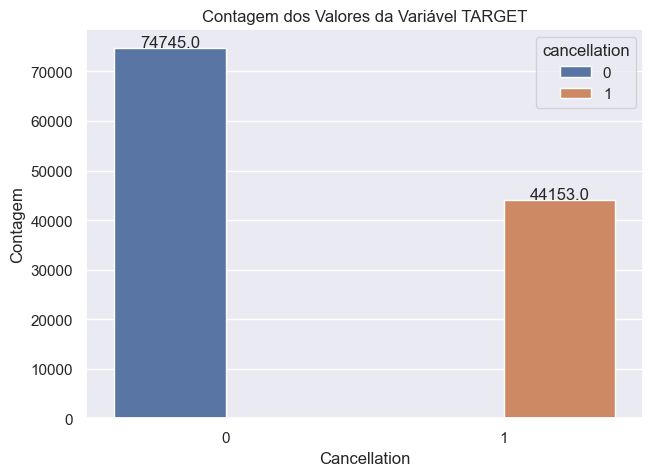

0    74745
1    44153
Name: cancellation, dtype: int64


0.59

In [1331]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que seu DataFrame seja chamado de 'df'
sns.countplot(data=df, x='cancellation', hue='cancellation')
plt.title('Contagem dos Valores da Variável TARGET')
plt.xlabel('Cancellation')
plt.ylabel('Contagem')

# Definindo a distância dos valores exibidos dentro das barras
distance = 1000  # Altere o valor conforme necessário

# Adicionando os valores de cada barra dentro das barras
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height() + distance), ha='center', va='center')

plt.show()
print(df['cancellation'].value_counts())
(df['cancellation'].value_counts()[1]/df['cancellation'].value_counts()[0]).round(2)

# Visualizar Dados Numéricos

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


days_between_booking_arrival


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


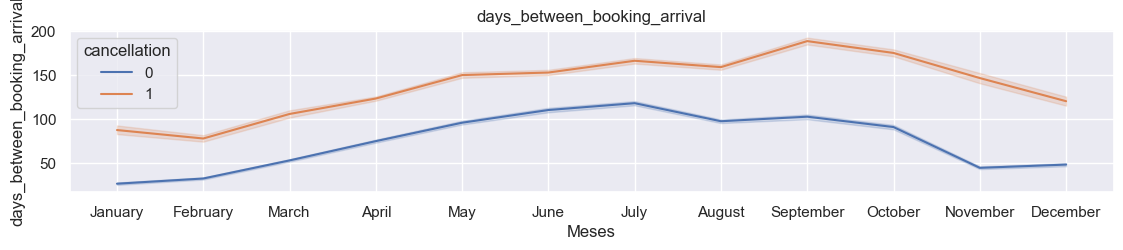

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


week_number_arrival_date


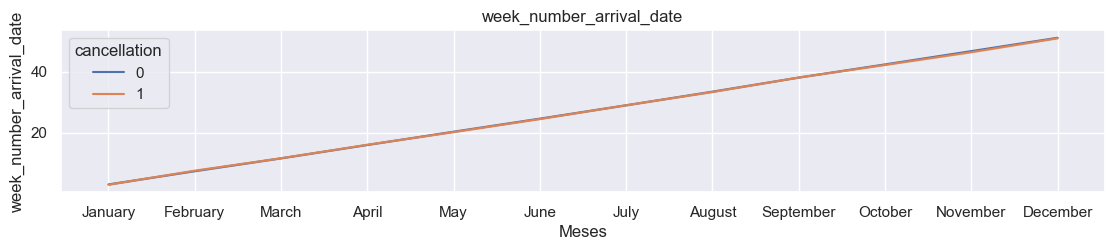

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


num_adults


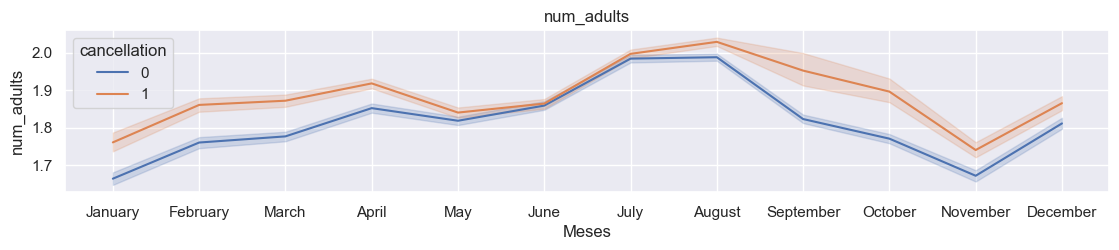

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


num_babies


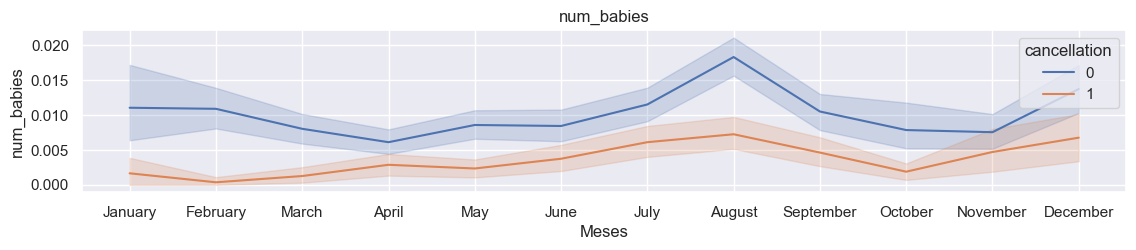

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


repeated_guest


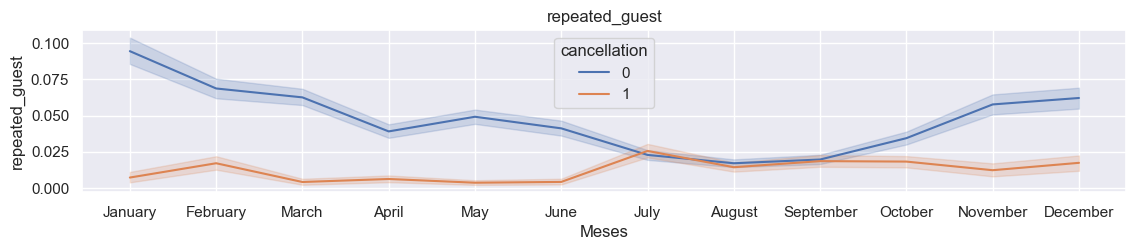

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


num_previous_cancellations


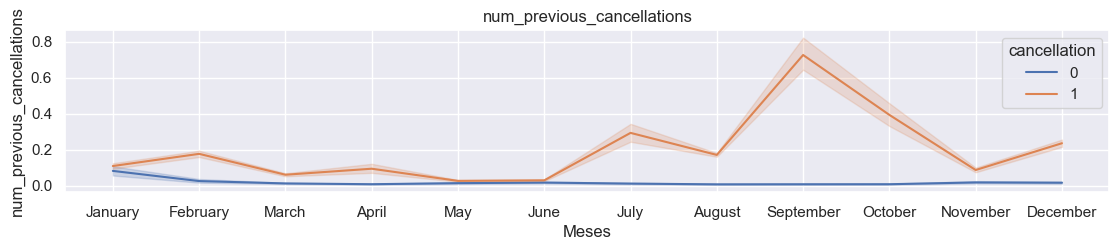

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


num_previous_stays


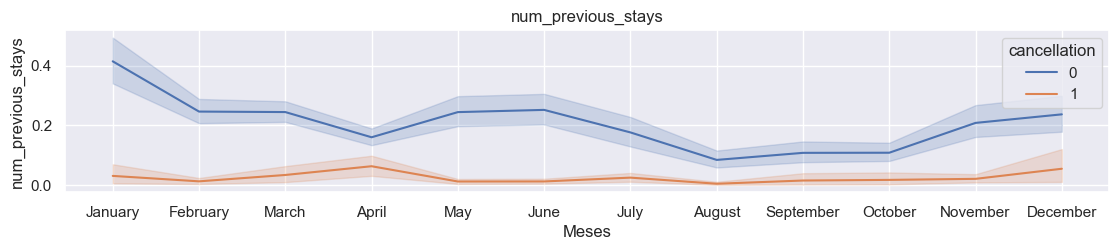

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


changes_between_booking_arrival


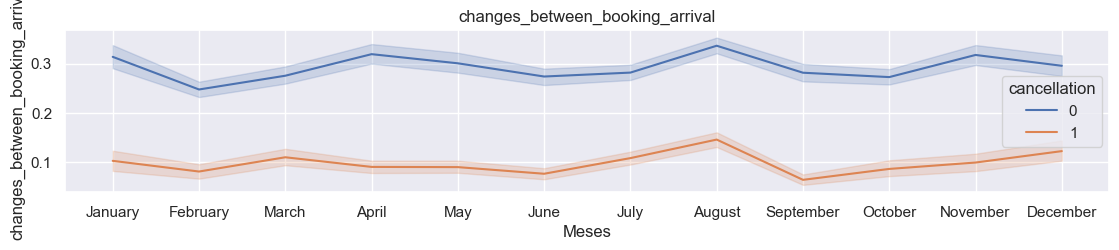

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


avg_price


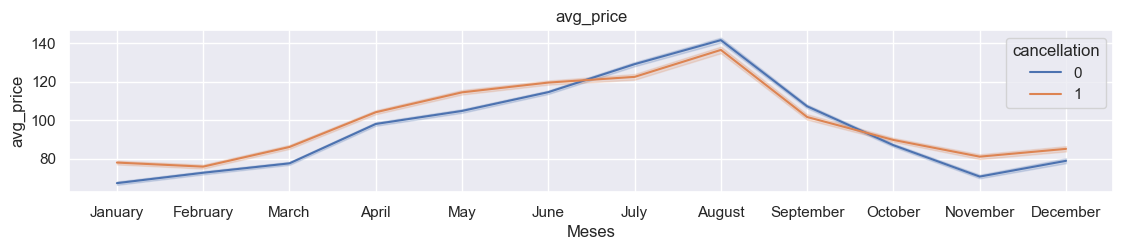

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


required_car_parking_spaces


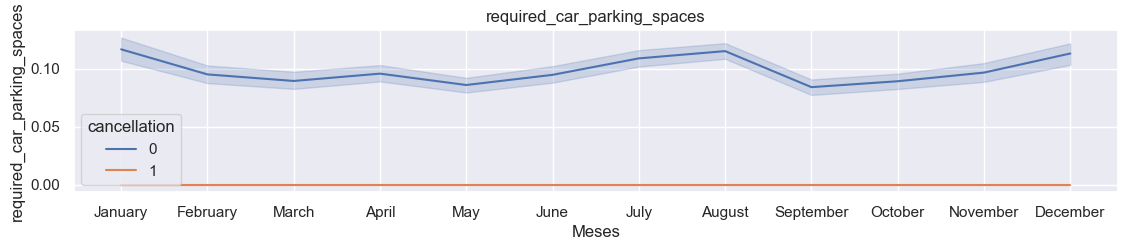

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


total_of_special_requests


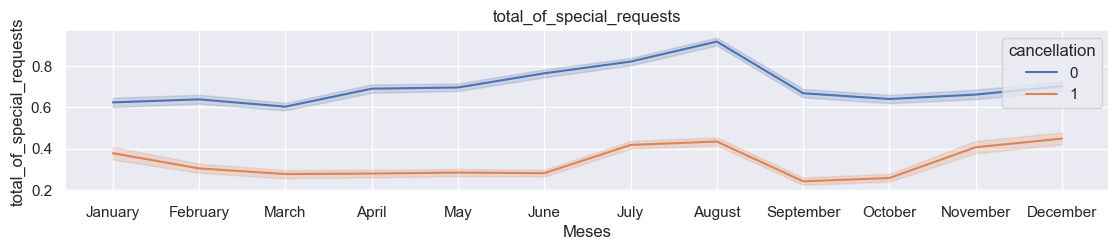

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Num_Noites


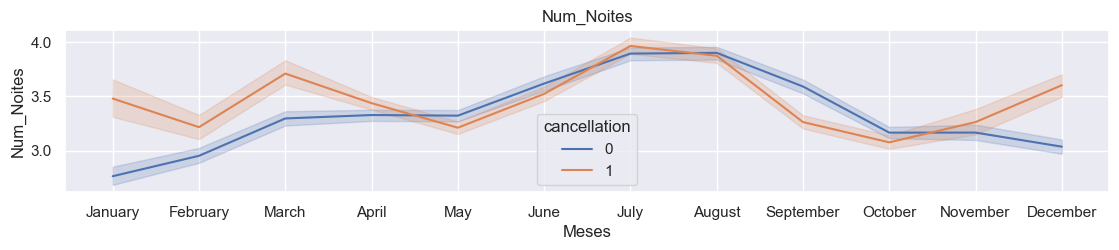

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


month_arrival_date


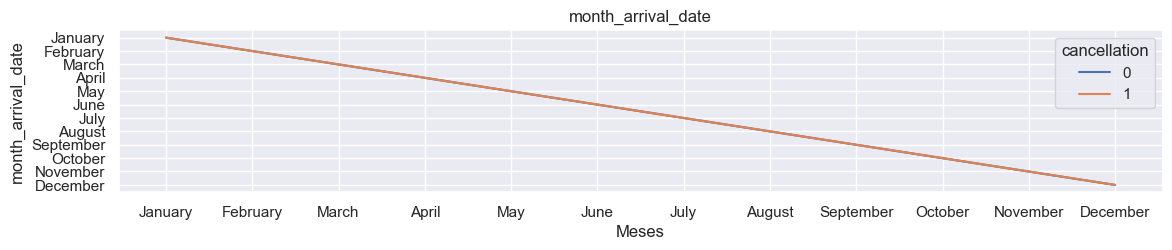

In [1342]:
df_numMes = pd.concat([df_num,df['month_arrival_date']],axis=1)

# Ordenar Meses
ordem_meses = ['January', 'February','March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# Converter a coluna month_arrival_date em um tipo categórico com a ordem correta dos meses
df_numMes['month_arrival_date'] = pd.Categorical(df_numMes['month_arrival_date'], categories=ordem_meses, ordered=True)


for i in df_numMes.columns[1:]:
    print(i)
    # Plotar o gráfico de linhas
    sns.set(style='darkgrid')
    chartSize = (12, 2)
    # Definir as dimensões da figura
    fig, ax = plt.subplots(figsize=chartSize)
    sns.lineplot(x='month_arrival_date', y=i, hue='cancellation', data=df_numMes)

    # Definir os rótulos e título do gráfico
    plt.xlabel('Meses')
    plt.ylabel(i)
    plt.title(i)
    plt.show()


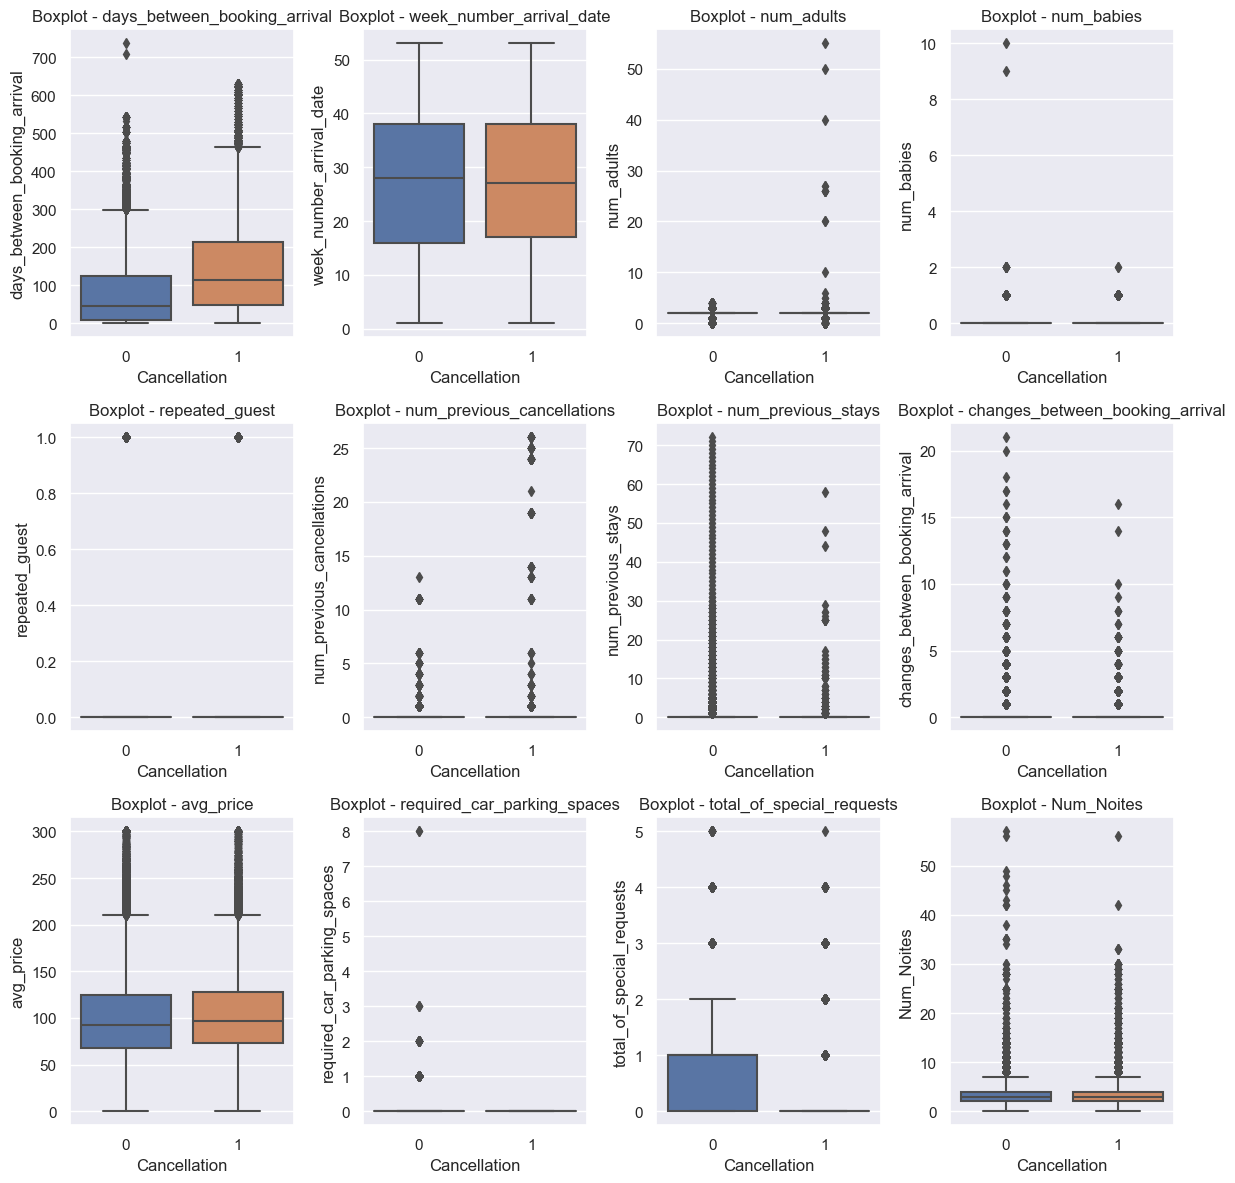

In [1343]:
# Determinar o número de colunas e linhas para o layout dos subplots
num_cols = 4
num_rows = 3

# Criar o layout dos subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Achatando o array de eixos
axes = np.ravel(axes)

# Iterar sobre as colunas numéricas e plotar os boxplots
for idx, col in enumerate(df_num.columns[1:num_cols*num_rows+1]):
    # Selecionar o eixo correto do subplot
    ax = axes[idx]
    
    # Plotar o boxplot diferenciado por 'cancellation'
    sns.boxplot(x='cancellation', y=col, data=df_num, ax=ax)
    
    # Configurar título e rótulos dos eixos
    ax.set_title(f'Boxplot - {col}')
    ax.set_xlabel('Cancellation')
    ax.set_ylabel(col)

# Remover subplots não utilizados
for idx in range(num_cols*num_rows, len(axes)):
    fig.delaxes(axes[idx])

# Ajustar o layout dos subplots
plt.tight_layout()

# Exibir a matriz de plots
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

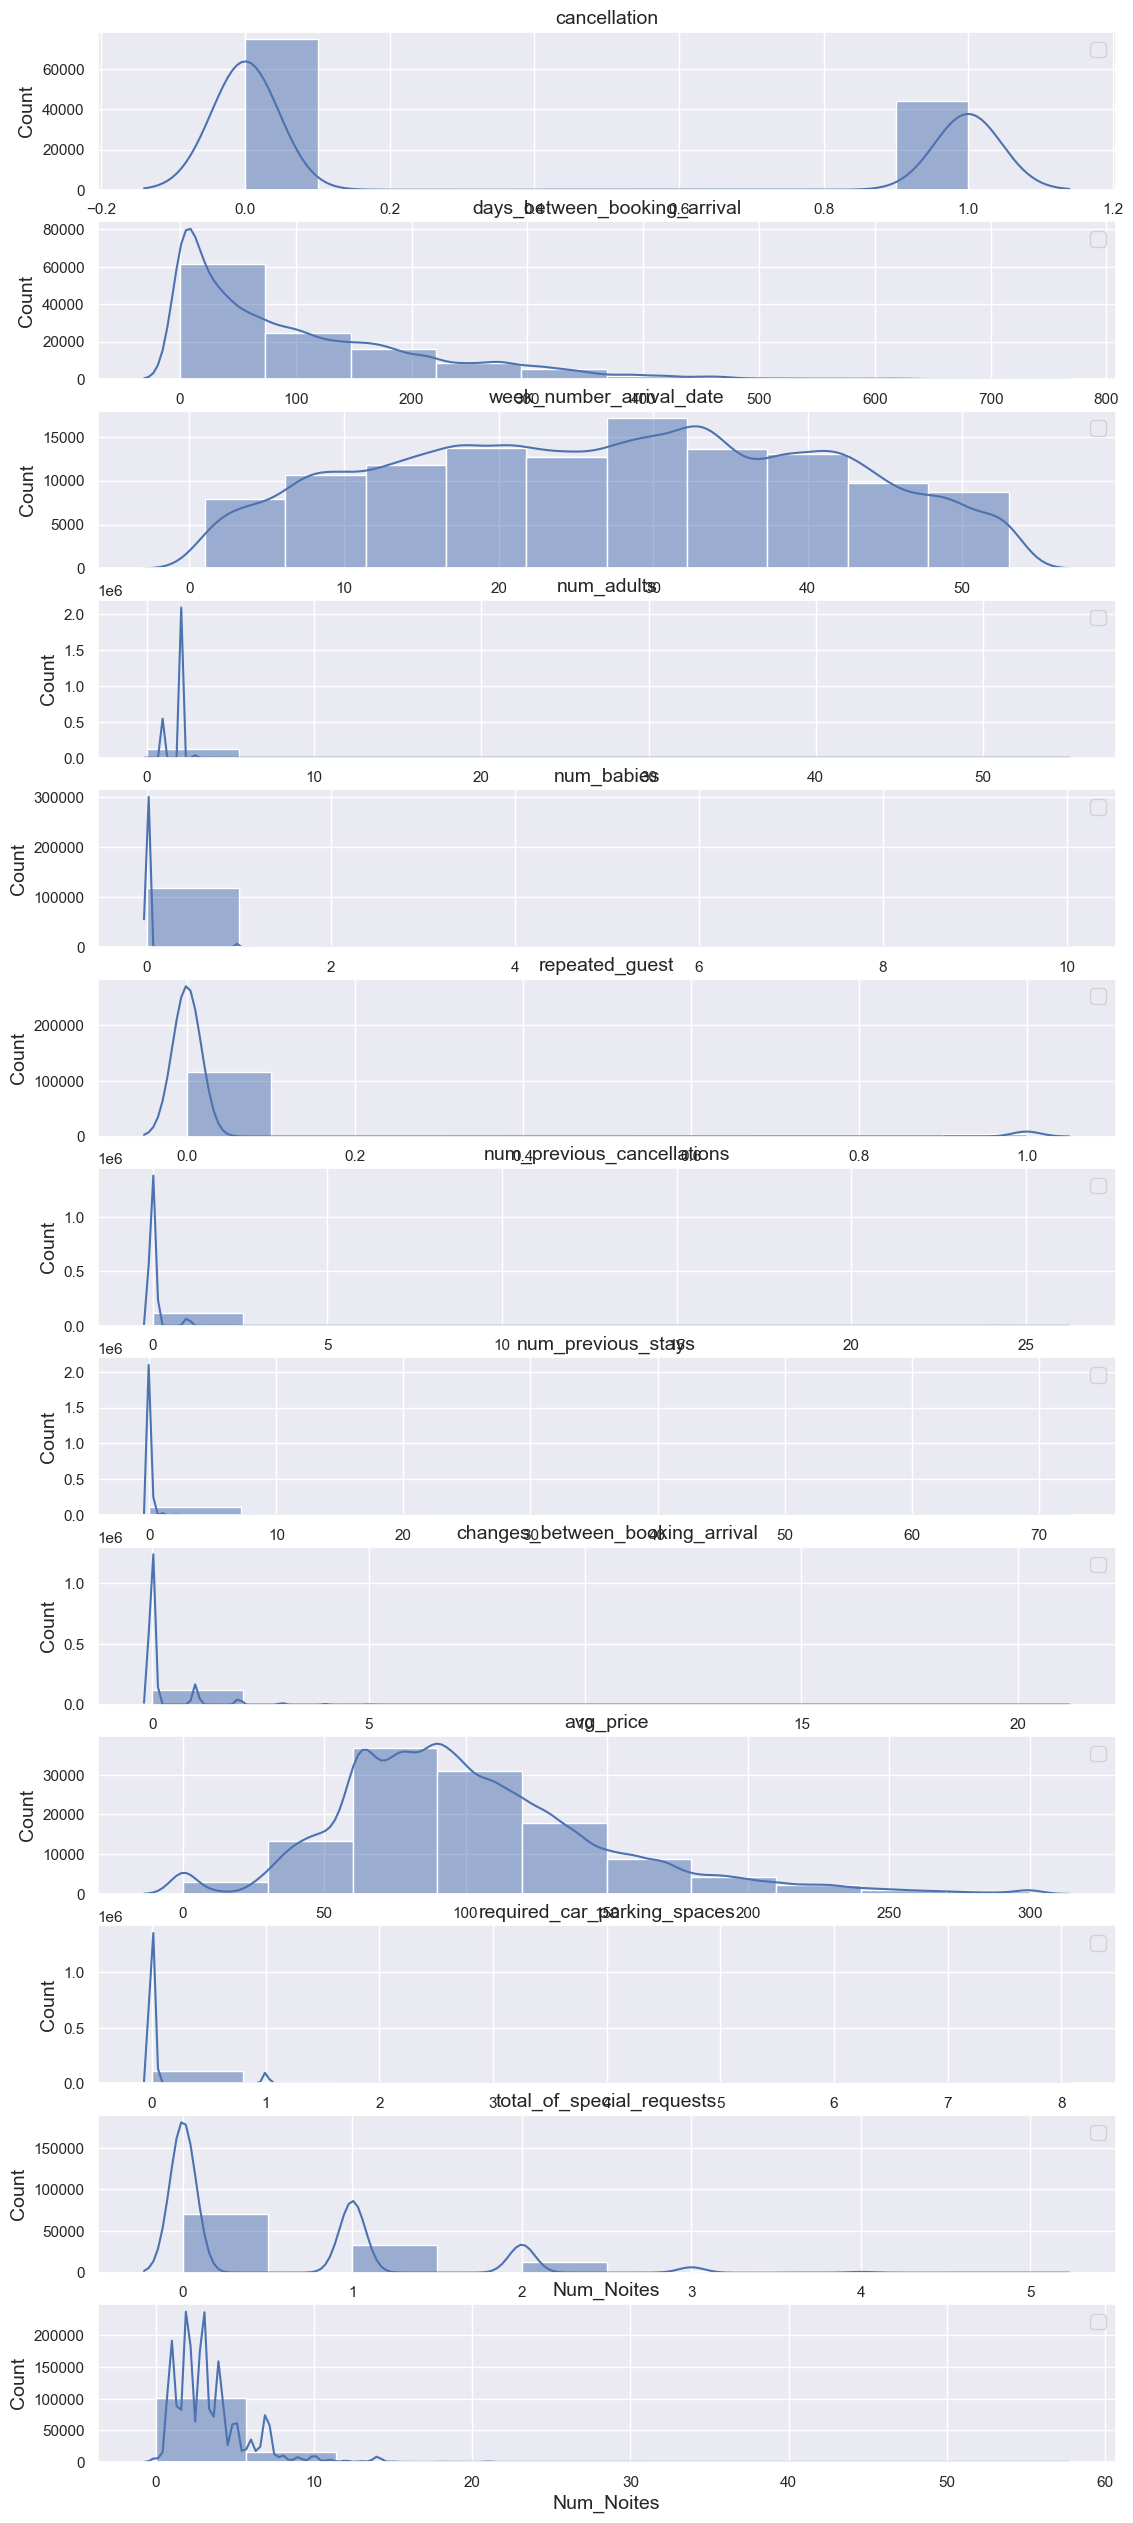

In [1344]:
font_size = 14  # Defina o tamanho da fonte desejado
histogram_seaborn(df_num,font_size)

### A partir dessas visualizações gráficas, percebemos que algumas variáveis do conjunto de dados, possuem padrões que podem sugerir um cancelamento.
    -'days_between_booking_arrival' Reservas Feitas com muitos dias de antecedência
    -'num_adults' Um número muito elevado de hóspedes
    -'required_car_parking_spaces' Nenhuma vaga de garagem solicitada

# 5. Feature Engenier

# Verificar Médias dos Preços Ao longo dos Meses
    - Vamos avaliar a flutuação dos preços e verificar se ha sazonalidade

In [1345]:
df_meses_avg_price = df[['cancellation','avg_price','month_arrival_date']]
df_meses_avg_price_hotel = df[['cancellation','avg_price','month_arrival_date']][df['type'] == 'Hotel']
df_meses_avg_price_FancyHotel = df[['cancellation','avg_price','month_arrival_date']][df['type'] == 'Fancy Hotel']

# Ordenar Meses
ordem_meses = ['January', 'February','March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# Converter a coluna month_arrival_date em um tipo categórico com a ordem correta dos meses
df_meses_avg_price['month_arrival_date'] = pd.Categorical(df_meses_avg_price['month_arrival_date'], categories=ordem_meses, ordered=True)
df_meses_avg_price_hotel['month_arrival_date'] = pd.Categorical(df_meses_avg_price_hotel['month_arrival_date'], categories=ordem_meses, ordered=True)
df_meses_avg_price_FancyHotel['month_arrival_date'] = pd.Categorical(df_meses_avg_price_FancyHotel['month_arrival_date'], categories=ordem_meses, ordered=True)

In [1346]:
df_meses_avg_price['avg_price'][df_meses_avg_price['month_arrival_date'] == 'July'].mean()

126.70402755780806

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

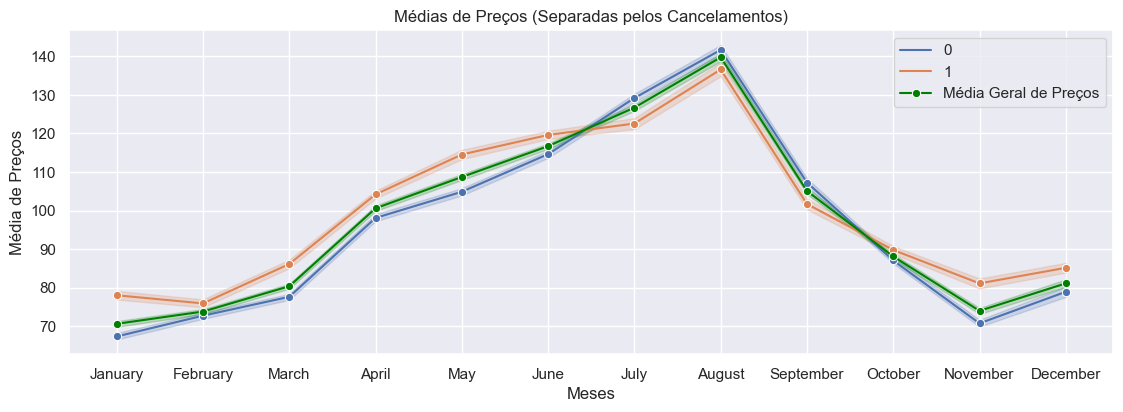

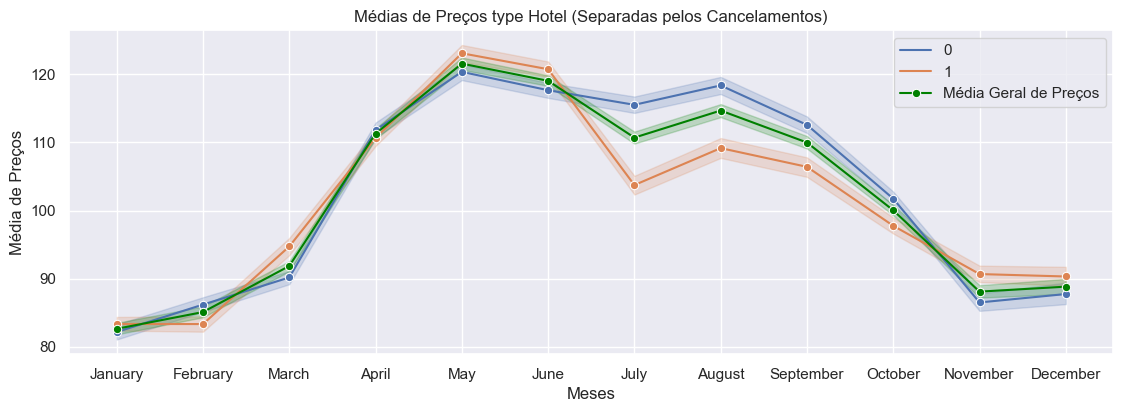

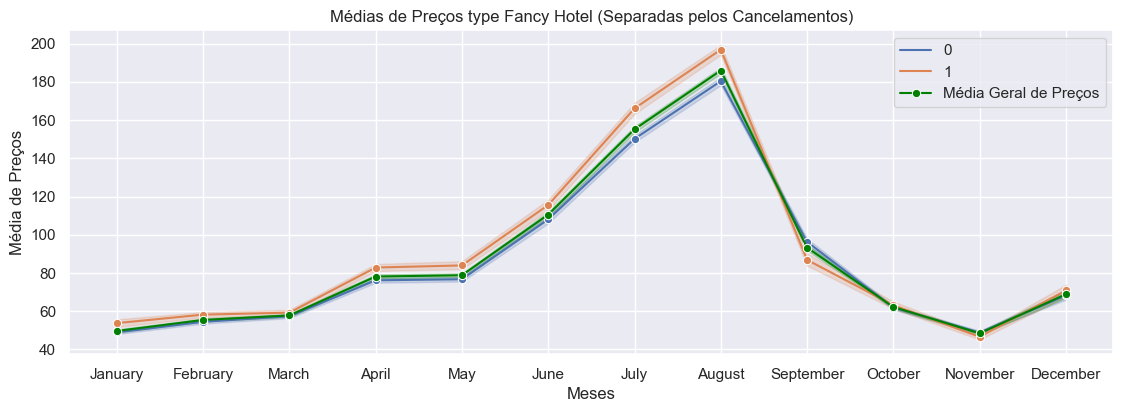

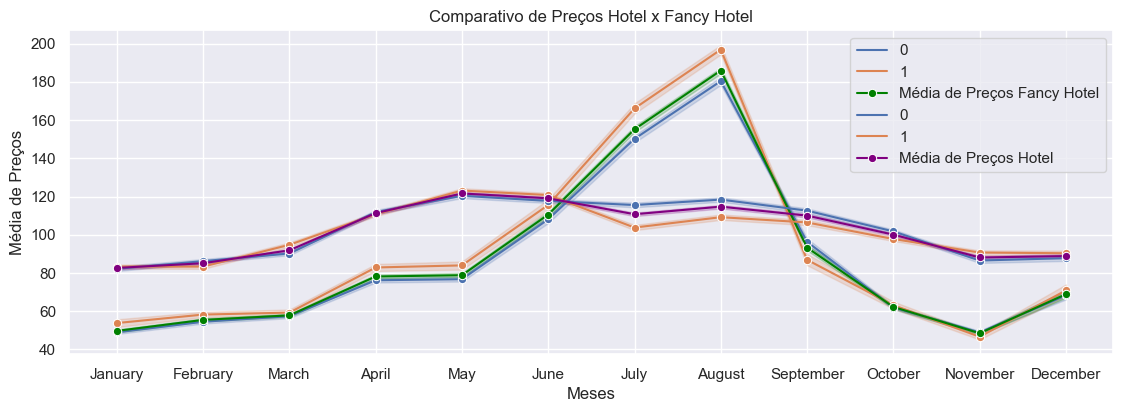

In [1347]:

sns.set(style='darkgrid')
chartSize = (12, 4)
# Definir as dimensões da figura
fig, ax = plt.subplots(figsize=chartSize)

# Plotar o gráfico de linhas
sns.lineplot(x='month_arrival_date', y='avg_price', hue='cancellation', data=df_meses_avg_price, marker='o', ax=ax)
sns.lineplot(x='month_arrival_date', y='avg_price', data=df_meses_avg_price, ax=ax, marker='o', color='green', label='Média Geral de Preços')

# Definir os rótulos e título do gráfico
plt.xlabel('Meses')
plt.ylabel('Média de Preços')
plt.title('Médias de Preços (Separadas pelos Cancelamentos)')

# ============================================================================================

# Definir as dimensões da figura
fig, ax = plt.subplots(figsize=chartSize)

# Plotar o gráfico de linhas
sns.lineplot(x='month_arrival_date', y='avg_price', hue='cancellation', data=df_meses_avg_price_hotel, marker='o', ax=ax)
sns.lineplot(x='month_arrival_date', y='avg_price', data=df_meses_avg_price_hotel, ax=ax, marker='o', color='green', label='Média Geral de Preços')

# Definir os rótulos e título do gráfico
plt.xlabel('Meses')
plt.ylabel('Média de Preços')
plt.title('Médias de Preços type Hotel (Separadas pelos Cancelamentos)')

# ================================================================================================

# Definir as dimensões da figura
fig, ax = plt.subplots(figsize=chartSize)

# Plotar o gráfico de linhas
sns.lineplot(x='month_arrival_date', y='avg_price', hue='cancellation', data=df_meses_avg_price_FancyHotel, marker='o', ax=ax)
sns.lineplot(x='month_arrival_date', y='avg_price', data=df_meses_avg_price_FancyHotel, marker='o', ax=ax, color='green', label='Média Geral de Preços')
# Definir os rótulos e título do gráfico
plt.xlabel('Meses')
plt.ylabel('Média de Preços')
plt.title('Médias de Preços type Fancy Hotel (Separadas pelos Cancelamentos)')

# Definir as dimensões da figura
fig, ax = plt.subplots(figsize=chartSize)

# Plotar o gráfico de linhas
sns.lineplot(x='month_arrival_date', y='avg_price', hue='cancellation', data=df_meses_avg_price_FancyHotel, marker='o', ax=ax)
sns.lineplot(x='month_arrival_date', y='avg_price', data=df_meses_avg_price_FancyHotel, marker='o', ax=ax, color='green', label='Média de Preços Fancy Hotel')

sns.lineplot(x='month_arrival_date', y='avg_price', hue='cancellation', data=df_meses_avg_price_hotel, marker='o', ax=ax)
sns.lineplot(x='month_arrival_date', y='avg_price', data=df_meses_avg_price_hotel, marker='o', ax=ax, color='purple', label='Média de Preços Hotel')


# Definir os rótulos e título do gráfico
plt.xlabel('Meses')
plt.ylabel('Média de Preços')
plt.title('Comparativo de Preços Hotel x Fancy Hotel')

# Exibir o gráfico
plt.show()

### 1. Os Gráficos Comprovam que ha sazonalidade de preços e que os cancelamentos de reservas reagem as variações.

### 2. Também podemos perceber, que em Hoteis de Alto Padrão, o número de cancelamentos aumenta entre junho e agosto, juntamente com a alta sinificativa dos preços. 

### 3. O mesmo não acontece nos Hotéis Standard, os cancelamentos são reduzidos consideravelmente entre junho e setembro.

### 4. Os preços de Hotel, apresentam menos variações no decorrer dos mesese
### 5. Os preços de Fancy Hotel, apresentam grande variação no decorrer dos mesese

# Verificar Reservas ao longo dos Meses

In [1348]:
df_reservas_meses = df[['cancellation','month_arrival_date']]
#df_meses_avg_price_hotel = df[['cancellation','avg_price','month_arrival_date']][df['type'] == 'Hotel']
#df_meses_avg_price_FancyHotel = df[['cancellation','avg_price','month_arrival_date']][df['type'] == 'Fancy Hotel']

# Ordenar Meses
ordem_meses = ['January', 'February','March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# Converter a coluna month_arrival_date em um tipo categórico com a ordem correta dos meses
df_reservas_meses['month_arrival_date'] = pd.Categorical(df_reservas_meses['month_arrival_date'], categories=ordem_meses, ordered=True)
df['month_arrival_date'] = pd.Categorical(df['month_arrival_date'], categories=ordem_meses, ordered=True)

In [1349]:
# Contar o número de ocorrências de cada valor em 'month_arrival_date'
counts = df['month_arrival_date'].value_counts()
counts_valid = df['month_arrival_date'][df['cancellation'] == 0].value_counts()
counts_cancelled = df['month_arrival_date'][df['cancellation'] == 1].value_counts()

# Contar o número de ocorrências de cada valor em 'month_arrival_date' Fancy Hotel
counts_FancyHotel = df['month_arrival_date'][df['type'] == 'Fancy Hotel'].value_counts()
counts_FancyHotel_valid = df['month_arrival_date'][(df['cancellation'] == 0) & (df['type'] == 'Fancy Hotel')].value_counts()
counts_FancyHotel_cancel = df['month_arrival_date'][(df['cancellation'] == 1) & (df['type'] == 'Fancy Hotel')].value_counts()

# Contar o número de ocorrências de cada valor em 'month_arrival_date' Hotel
counts_Hotel = df['month_arrival_date'][df['type'] == 'Hotel'].value_counts()
counts_Hotel_valid = df['month_arrival_date'][(df['cancellation'] == 0) & (df['type'] == 'Hotel')].value_counts()
counts_Hotel_cancel = df['month_arrival_date'][(df['cancellation'] == 1) & (df['type'] == 'Hotel')].value_counts()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

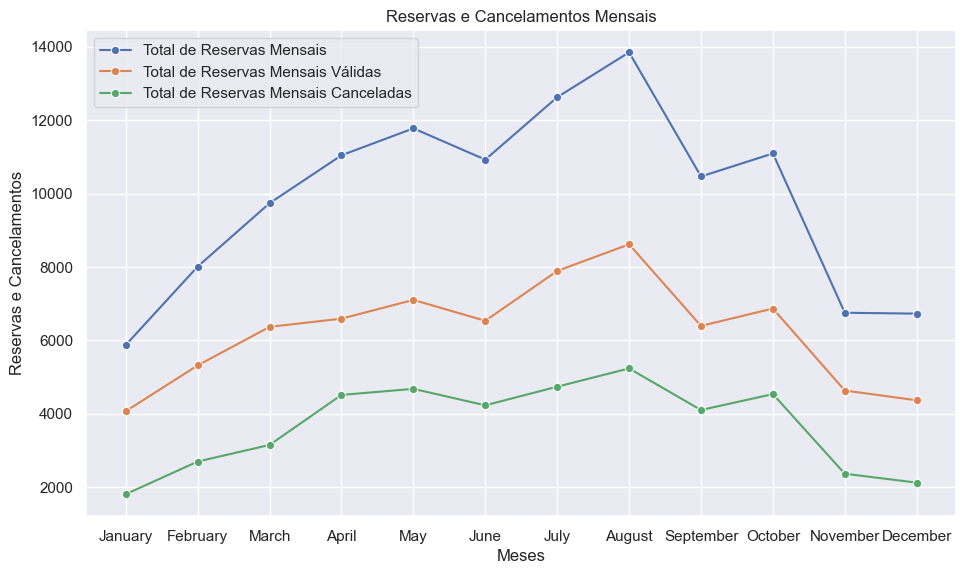

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

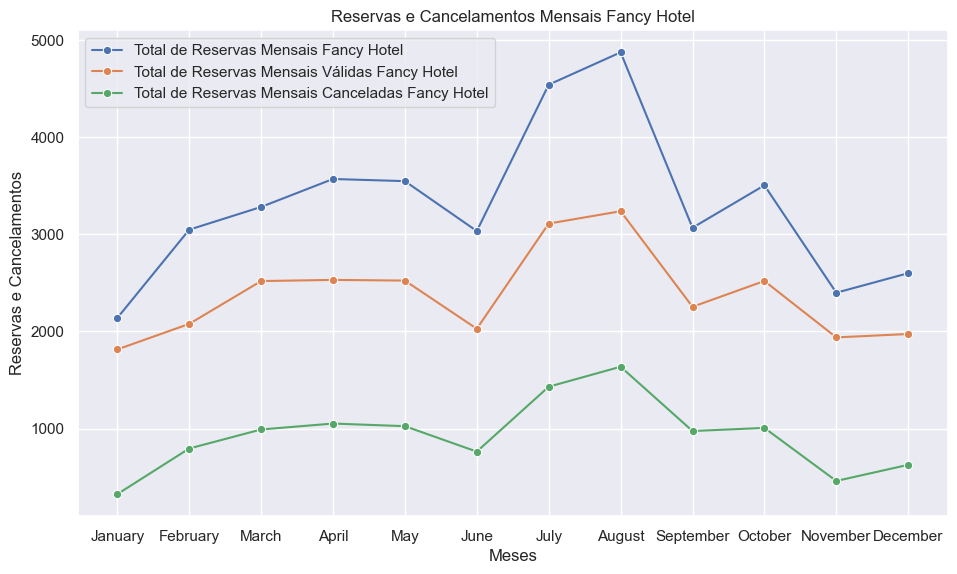

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

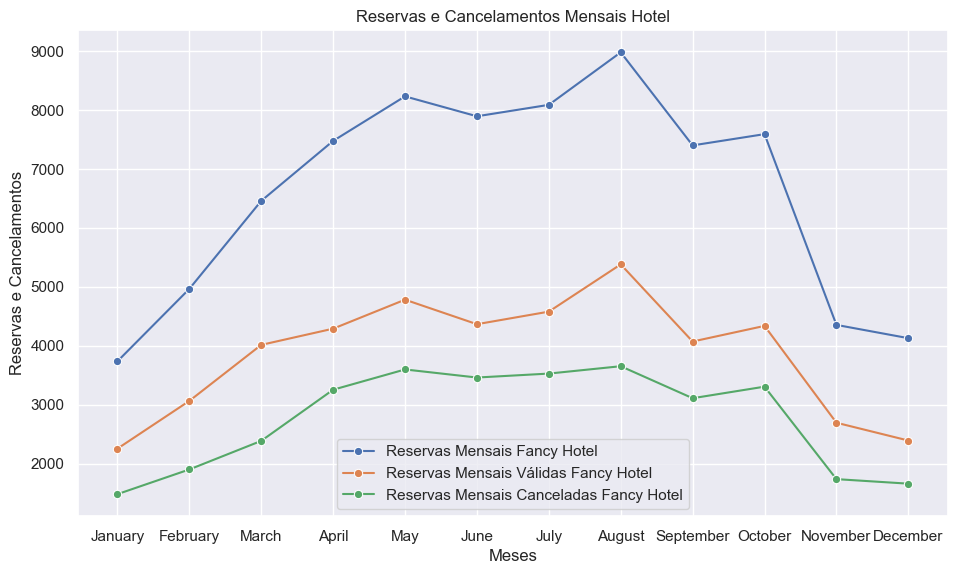

In [1350]:
# Definir as dimensões da figura
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar o gráfico de linhas# =========================================
sns.lineplot(x=counts.index, y=counts.values, marker='o', ax=ax, label='Total de Reservas Mensais')

# Plotar o gráfico de linhas# =========================================
sns.lineplot(x=counts.index, y=counts_valid.values, marker='o', ax=ax, label='Total de Reservas Mensais Válidas')

# Plotar o gráfico de linhas# =========================================
sns.lineplot(x=counts.index, y=counts_cancelled.values, marker='o', ax=ax, label='Total de Reservas Mensais Canceladas')

# Definir os rótulos e título do gráfico
plt.xlabel('Meses')
plt.ylabel('Reservas e Cancelamentos')
plt.title('Reservas e Cancelamentos Mensais')
plt.show()


# FANCY HOTEL =================================================================================================
# Plotar o gráfico de linhas# =========================================
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=counts_FancyHotel.index, y=counts_FancyHotel.values, marker='o', ax=ax, label='Total de Reservas Mensais Fancy Hotel')

# Plotar o gráfico de linhas# =========================================
sns.lineplot(x=counts_FancyHotel.index, y=counts_FancyHotel_valid.values, marker='o', ax=ax, label='Total de Reservas Mensais Válidas Fancy Hotel')

# Plotar o gráfico de linhas# =========================================
sns.lineplot(x=counts_FancyHotel.index, y=counts_FancyHotel_cancel.values, marker='o', ax=ax, label='Total de Reservas Mensais Canceladas Fancy Hotel')

# Definir os rótulos e título do gráfico
plt.xlabel('Meses')
plt.ylabel('Reservas e Cancelamentos')
plt.title('Reservas e Cancelamentos Mensais Fancy Hotel')

plt.show()




# HOTEL =================================================================================================
# Plotar o gráfico de linhas# =========================================
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=counts_Hotel.index, y=counts_Hotel.values, marker='o', ax=ax, label='Reservas Mensais Fancy Hotel')

# Plotar o gráfico de linhas# =========================================
sns.lineplot(x=counts_Hotel.index, y=counts_Hotel_valid.values, marker='o', ax=ax, label='Reservas Mensais Válidas Fancy Hotel')

# Plotar o gráfico de linhas# =========================================
sns.lineplot(x=counts_Hotel.index, y=counts_Hotel_cancel.values, marker='o', ax=ax, label='Reservas Mensais Canceladas Fancy Hotel')

# Definir os rótulos e título do gráfico
plt.xlabel('Meses')
plt.ylabel('Reservas e Cancelamentos')
plt.title('Reservas e Cancelamentos Mensais Hotel')

plt.show()

### Segundo os gráficos acima, a sazonalidade das reservas possui diferenas entre cada tipo de Hotel

# Verificar Número de Reservas por tipo de Acomodação ao longo do ano

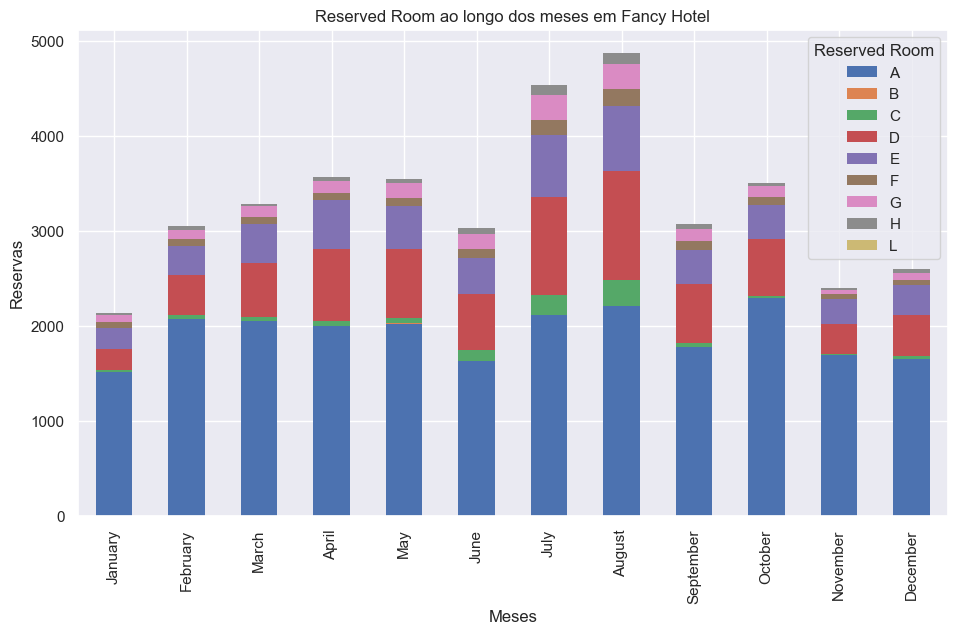

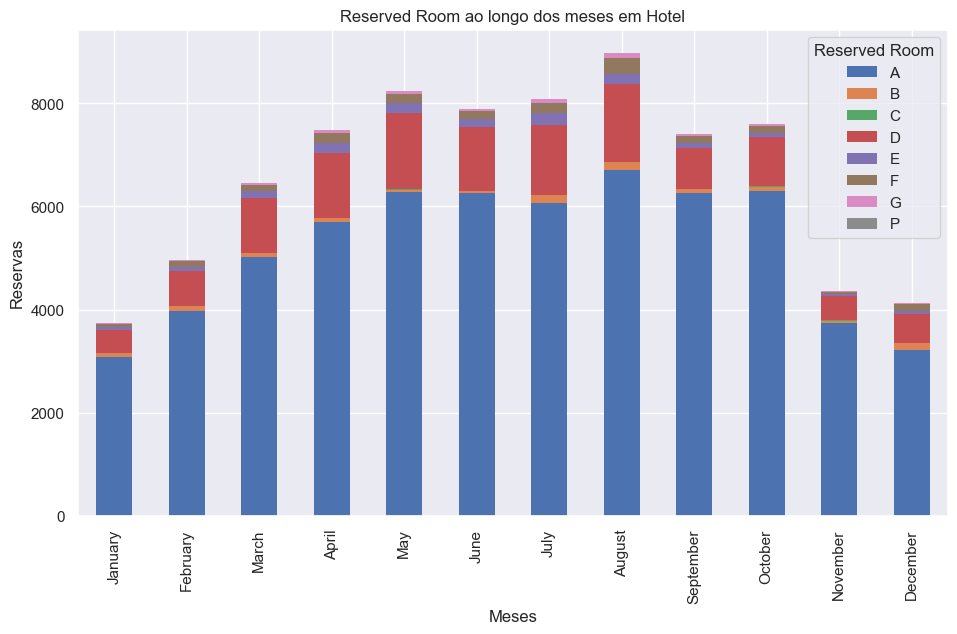

********FANCY HOTEL Absoluto************
reserved_room          A  B    C     D    E    F    G    H  L
month_arrival_date                                           
January             1515  0   16   222  224   67   68   26  0
February            2068  0   44   418  309   73   97   38  0
March               2055  0   40   561  415   74  112   24  0
April               1996  1   58   749  515   81  129   40  0
May                 2024  1   59   727  450   88  154   44  0
June                1631  0  111   597  371   98  154   71  0
July                2109  1  212  1030  655  162  259  108  4
August              2212  0  266  1154  687  174  268  110  2
September           1780  0   42   613  367   92  128   45  0
October             2288  0   21   603  361   84  113   34  0
November            1690  0   16   308  272   49   44   19  0
December            1654  0   32   423  318   57   73   42  0

********FANCY HOTEL Percentual************
reserved_room          A    B    C     D     E 

In [1351]:
# Ordenar Meses
ordem_meses = ['January', 'February','March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

df_ReserverdRoom_reservas_FancyHotel = df[['cancellation', 'month_arrival_date', 'reserved_room']][df['type'] == 'Fancy Hotel']
df_ReserverdRoom_reservas_Hotel = df[['cancellation', 'month_arrival_date', 'reserved_room']][df['type'] == 'Hotel']

# Converter a coluna month_arrival_date em um tipo categórico com a ordem correta dos meses
df_ReserverdRoom_reservas_FancyHotel['month_arrival_date'] = pd.Categorical(df_ReserverdRoom_reservas_FancyHotel['month_arrival_date'], categories=ordem_meses, ordered=True)
df_ReserverdRoom_reservas_Hotel['month_arrival_date'] = pd.Categorical(df_ReserverdRoom_reservas_Hotel['month_arrival_date'], categories=ordem_meses, ordered=True)

counts_FancyHotel = df_ReserverdRoom_reservas_FancyHotel.groupby(['month_arrival_date', 'reserved_room']).size().unstack(fill_value=0)
counts_Hotel = df_ReserverdRoom_reservas_Hotel.groupby(['month_arrival_date', 'reserved_room']).size().unstack(fill_value=0)

# Cálculo dos percentuais
counts_FancyHotel_pct = counts_FancyHotel.apply(lambda x: (x / x.sum()) * 100, axis=1)
counts_FancyHotel_pct = pd.DataFrame(counts_FancyHotel_pct)

counts_Hotel_pct = counts_Hotel.apply(lambda x: (x / x.sum()) * 100, axis=1)
counts_Hotel_pct = pd.DataFrame(counts_Hotel_pct)

counts_FancyHotel.plot(kind='bar', stacked=True, figsize=(10, 6), edgecolor='none')
plt.xlabel('Meses')
plt.ylabel('Reservas')
plt.title('Reserved Room ao longo dos meses em Fancy Hotel')
plt.legend(title='Reserved Room')

counts_Hotel.plot(kind='bar', stacked=True, figsize=(10, 6), edgecolor='none')
plt.xlabel('Meses')
plt.ylabel('Reservas')
plt.title('Reserved Room ao longo dos meses em Hotel')
plt.legend(title='Reserved Room')

plt.show()
print('********FANCY HOTEL Absoluto************')
print(counts_FancyHotel)
print('\n********FANCY HOTEL Percentual************')
print(counts_FancyHotel_pct)
print('\n********HOTEL Absoluto************')
print(counts_Hotel)
print('\n********HOTEL Percentual************')
print(counts_Hotel_pct)

### Com essa analise, percebemos que entre os dois tipos de Hotéis, os padrões de Reservas de hospedagens são bem distintos 

# Verificar Nacionalidade das reservas

In [1352]:
# Reservas totasi
df_Country_reservas =  df[['cancellation','month_arrival_date','country']]
df_Country_reservas['Values_country'] = df_Country_reservas['country'].value_counts()
Country_reservas = pd.DataFrame(df_Country_reservas['country'].value_counts())
Country_reservas = Country_reservas.rename(columns = {'country':'Reservas'})

# Reservas Confirmadas
df_Country_reservas_conf =  df[['cancellation','month_arrival_date','country']][df['cancellation'] == 0]
df_Country_reservas_conf['Values_country'] = df_Country_reservas_conf['country'].value_counts()
Country_reservas_conf = pd.DataFrame(df_Country_reservas_conf['country'].value_counts())
Country_reservas_conf = Country_reservas_conf.rename(columns = {'country':'Confirmadas'})

# Reservas Confirmadas
df_Country_reservas_canc =  df[['cancellation','month_arrival_date','country']][df['cancellation'] == 1]
df_Country_reservas_canc['Values_country'] = df_Country_reservas_canc['country'].value_counts()
Country_reservas_canc = pd.DataFrame(df_Country_reservas_canc['country'].value_counts())
Country_reservas_canc = Country_reservas_canc.rename(columns = {'country':'Canceladas'})

### Analisar Reservas e cacelamentos por país e sua representatividade no total

In [1353]:
df_reservas = pd.concat([Country_reservas, Country_reservas_conf, Country_reservas_canc], axis=1)
df_reservas = df_reservas.fillna(0).astype(int)
df_reservas['Cance_%'] = df_reservas['Canceladas'] / df_reservas['Reservas']
df_reservas['Conf_%'] = df_reservas['Confirmadas'] / df_reservas['Reservas']
df_reservas['Total_Reserva%'] = df_reservas['Reservas'] / df_reservas['Reservas'].sum()
df_reservas['Total_Canc%'] = df_reservas['Canceladas'] / df_reservas['Canceladas'].sum()
df_reservas['Total_Conf%'] = df_reservas['Confirmadas'] / df_reservas['Confirmadas'].sum()
print(df_reservas['Reservas'].sum())

118898


### Ordenar Resultados

In [1354]:
df_reservas.head(20).sort_values('Cance_%', ascending=False)

,Reservas,Confirmadas,Canceladas,Cance_%,Conf_%,Total_Reserva%,Total_Canc%,Total_Conf%
PRT,48586,21071,27515,0.57,0.43,0.41,0.62,0.28
CHN,999,537,462,0.46,0.54,0.01,0.01,0.01
RUS,632,393,239,0.38,0.62,0.01,0.01,0.01
BRA,2224,1394,830,0.37,0.63,0.02,0.02,0.02
ITA,3766,2433,1333,0.35,0.65,0.03,0.03,0.03
NOR,607,426,181,0.30,0.70,0.01,0.00,0.01
ESP,8568,6391,2177,0.25,0.75,0.07,0.05,0.09
ISR,669,500,169,0.25,0.75,0.01,0.00,0.01
CHE,1730,1302,428,0.25,0.75,0.01,0.01,0.02
IRL,3375,2543,832,0.25,0.75,0.03,0.02,0.03


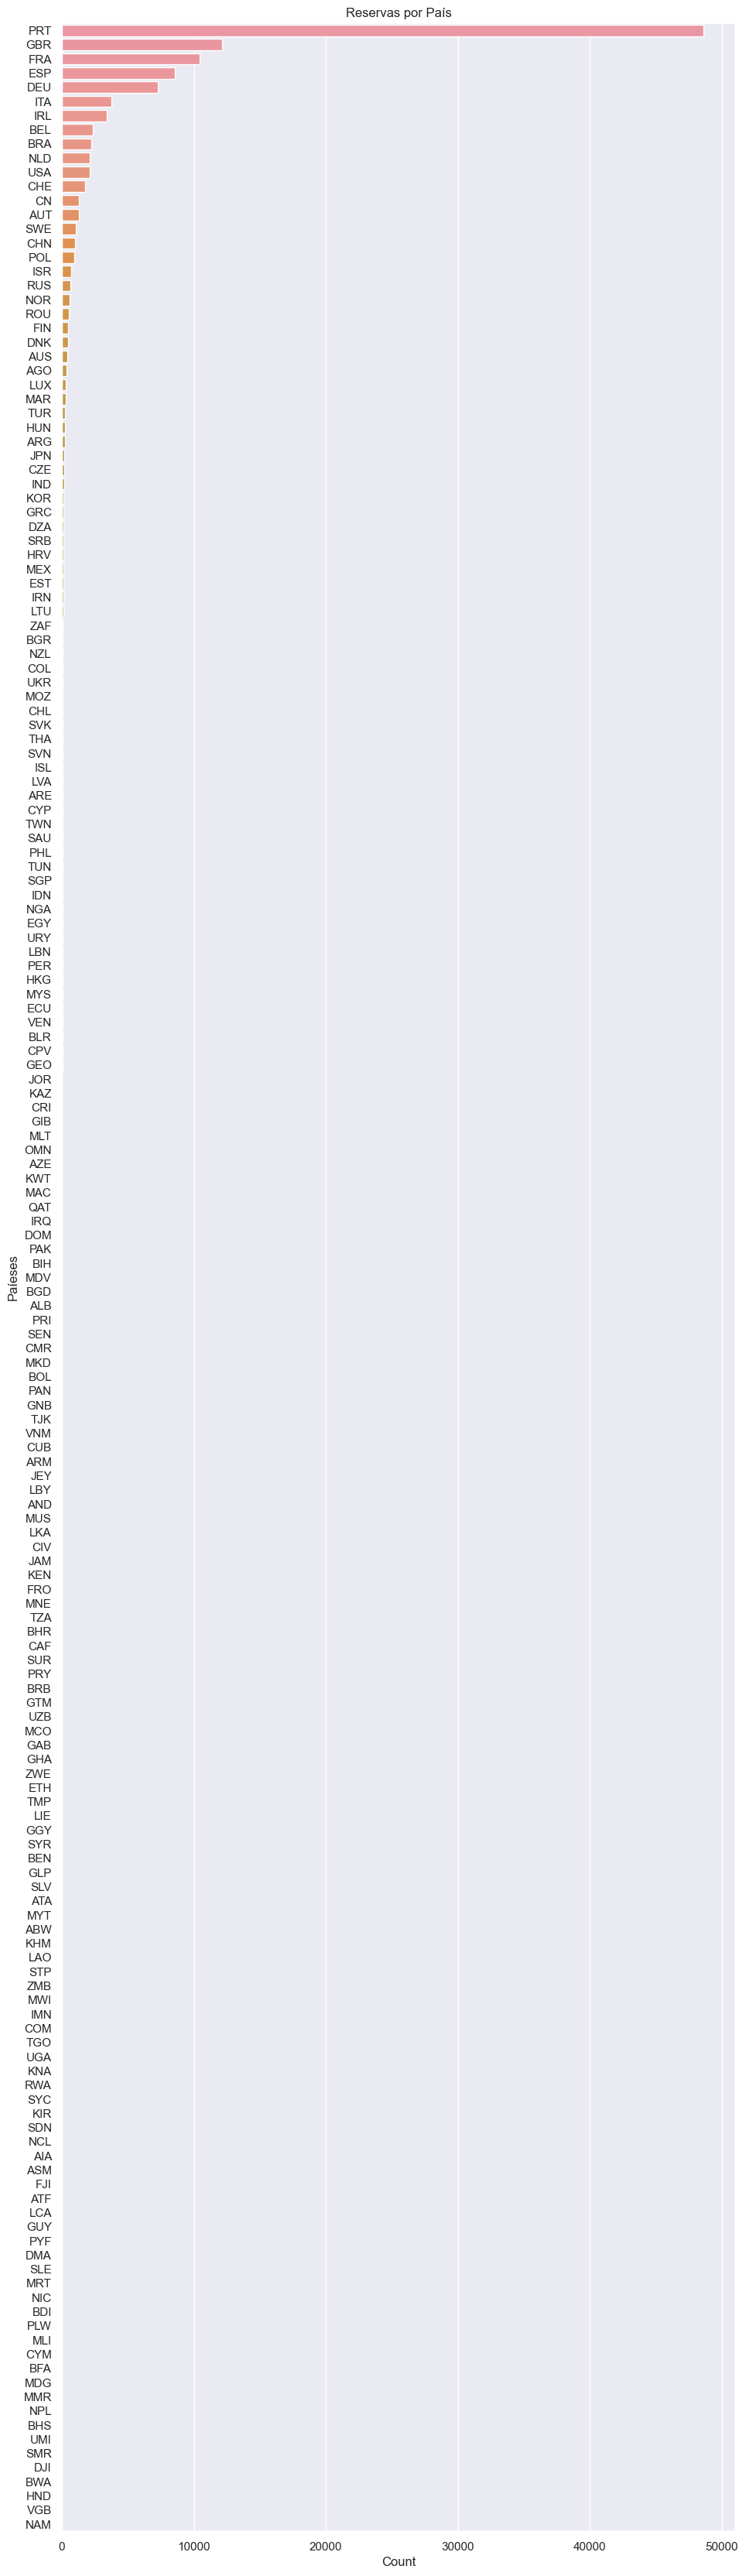

In [1355]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir as dimensões da figura
fig, ax = plt.subplots(figsize=(10, 40))

# Criar o gráfico de barras horizontais utilizando o Seaborn e aumentar a espessura das barras
sns.barplot(x='Reservas', y=Country_reservas.index, data=Country_reservas, ax=ax)

# Adicionar rótulos aos eixos e título do gráfico
plt.xlabel('Count')
plt.ylabel('Paíeses')
plt.title('Reservas por País')

plt.show()

### Proporcionalmente, os países que mais confirmam hospedagem, não são os que mais realizam reservas
### Portugal cancela cerca de 60% de suas reservas

In [1416]:
# Tempo Médio de Hospedagem


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

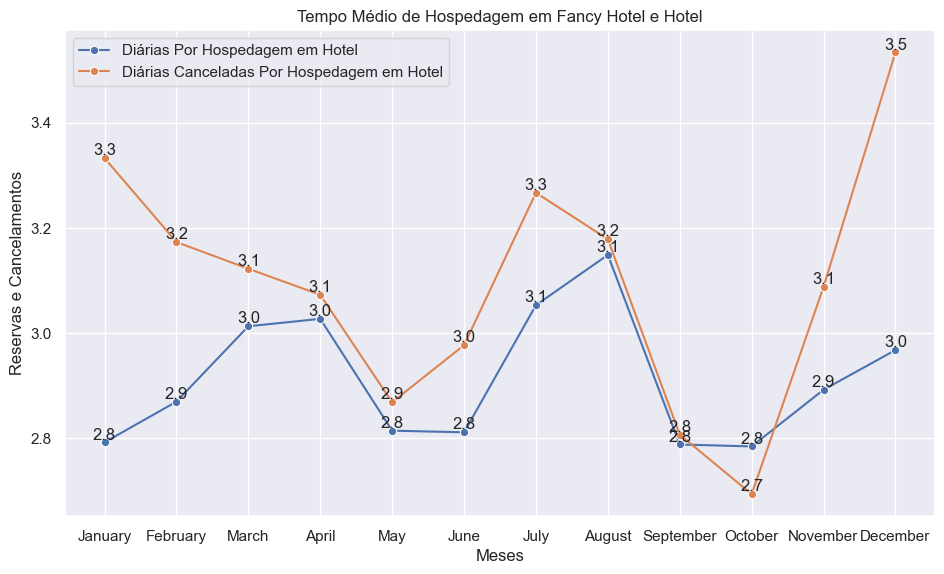

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

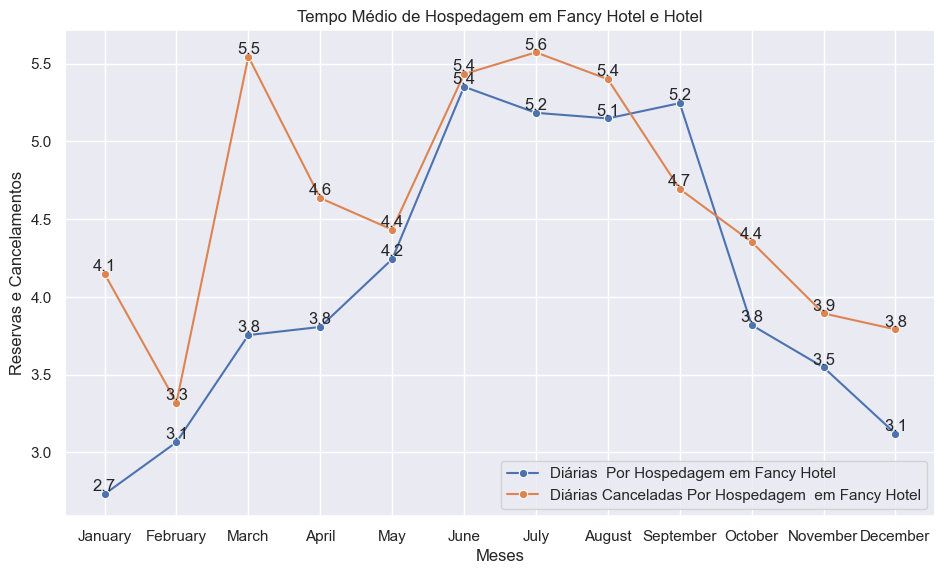

In [1420]:
df_hospedagem_temp = df_numMes
df_hospedagem_temp = pd.concat([df_hospedagem_temp,df['type']],axis=1)
df_hospedagem_temp = df_hospedagem_temp[(df_hospedagem_temp['cancellation'] == 0)&(df_hospedagem_temp['type'] == 'Hotel')]
mean_days_hotel = df_hospedagem_temp.groupby('month_arrival_date')['Num_Noites'].mean()

df_hospedagem_temp_1 = df_numMes
df_hospedagem_temp_1 = pd.concat([df_hospedagem_temp_1,df['type']],axis=1)
df_hospedagem_temp_1 = df_hospedagem_temp_1[(df_hospedagem_temp_1['cancellation'] == 1)&(df_hospedagem_temp_1['type'] == 'Hotel')]
mean_days_hotel_1 = df_hospedagem_temp_1.groupby('month_arrival_date')['Num_Noites'].mean()

df_hospedagem_temp = df_numMes
df_hospedagem_temp = pd.concat([df_hospedagem_temp,df['type']],axis=1)
df_hospedagem_temp = df_hospedagem_temp[(df_hospedagem_temp['cancellation'] == 0)&(df_hospedagem_temp['type'] == 'Fancy Hotel')]
mean_days_fancyHotel = df_hospedagem_temp.groupby('month_arrival_date')['Num_Noites'].mean()

df_hospedagem_temp_2 = df_numMes
df_hospedagem_temp_2 = pd.concat([df_hospedagem_temp_2,df['type']],axis=1)
df_hospedagem_temp_2 = df_hospedagem_temp_2[(df_hospedagem_temp_2['cancellation'] == 1)&(df_hospedagem_temp_2['type'] == 'Fancy Hotel')]
mean_days_Fancehotel_2 = df_hospedagem_temp_2.groupby('month_arrival_date')['Num_Noites'].mean()

# Plotar Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=mean_days_hotel.index, y=mean_days_hotel.values, marker='o', ax=ax, label='Diárias Por Hospedagem em Hotel')
sns.lineplot(x=mean_days_hotel.index, y=mean_days_hotel_1.values, marker='o', ax=ax, label='Diárias Canceladas Por Hospedagem em Hotel')


# Adicionar valores nos pontos do gráfico
for x, y in zip(mean_days_hotel.index, mean_days_hotel_1.values):
    ax.text(x, y, str(round(y, 1)), ha='center', va='bottom')

# Adicionar valores nos pontos do gráfico
for x, y in zip(mean_days_hotel.index, mean_days_hotel.values):
    ax.text(x, y, str(round(y, 1)), ha='center', va='bottom')

# Definir os rótulos e título do gráfico
plt.xlabel('Meses')
plt.ylabel('Reservas e Cancelamentos')
plt.title('Tempo Médio de Hospedagem em Fancy Hotel e Hotel')

plt.show()




# Plotar Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=mean_days_hotel.index, y=mean_days_fancyHotel.values, marker='o', ax=ax, label='Diárias  Por Hospedagem em Fancy Hotel')
sns.lineplot(x=mean_days_hotel.index, y=mean_days_Fancehotel_2.values, marker='o', ax=ax, label='Diárias Canceladas Por Hospedagem  em Fancy Hotel')

# Adicionar valores nos pontos do gráfico
for x, y in zip(mean_days_hotel.index, mean_days_Fancehotel_2.values):
    ax.text(x, y, str(round(y, 1)), ha='center', va='bottom')

for x, y in zip(mean_days_hotel.index, mean_days_fancyHotel.values):
    ax.text(x, y, str(round(y, 1)), ha='center', va='bottom')

# Definir os rótulos e título do gráfico
plt.xlabel('Meses')
plt.ylabel('Reservas e Cancelamentos')
plt.title('Tempo Médio de Hospedagem em Fancy Hotel e Hotel')

plt.show()


In [1358]:
print('*'*40)
print('Desvio Padrão do Número de Diárias')
print('*'*40)
print(mean_days_hotel.std(),'Type: Hotel')
print(mean_days_fancyHotel.std(), 'Type: Fancy Hotel')

****************************************
Desvio Padrão do Número de Diárias
****************************************
0.12433600817960043 Type: Hotel
0.9378199871823475 Type: Fancy Hotel


In [1359]:
df.groupby('type')['Num_Noites'].value_counts()

type         Num_Noites
Fancy Hotel  1              7525
             7              6575
             2              6105
             3              5659
             4              4807
             5              2768
             6              1791
             10              936
             14              813
             8               772
             9               625
             0               377
             11              313
             12              158
             13               98
             21               61
             25               35
             15               32
             28               31
             18               28
             16               24
             17               12
             19               10
             22                7
             23                6
             30                5
             35                5
             42                4
             26                3
             29    

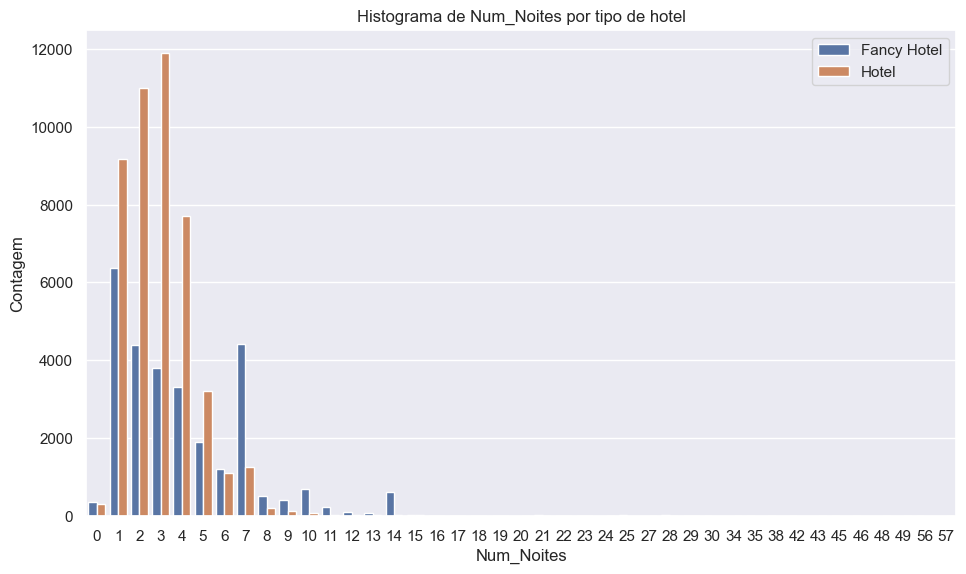

In [1360]:
df_diarias = df[['type','Num_Noites']][df['cancellation'] == 0]
df_diarias.groupby(['Num_Noites']).agg('count').reset_index()

df_diarias = df[['type', 'Num_Noites']][df['cancellation'] == 0]
df_diarias_counts = df_diarias.groupby(['Num_Noites', 'type']).size().reset_index(name='count')

# Definir o tamanho da figura
plt.figure(figsize=(10, 6))

# Plotar o histograma para o tipo de hotel 'Hotel'
sns.barplot(data=df_diarias_counts, x='Num_Noites', y='count', hue='type')

# Definir o título e rótulos dos eixos
plt.title('Histograma de Num_Noites por tipo de hotel')
plt.xlabel('Num_Noites')
plt.ylabel('Contagem')

# Exibir a legenda na direita superior
plt.legend(loc='upper right')

# Exibir o histograma
plt.show()

# Plotar Variáveis Categóricas

<Figure size 1000x600 with 0 Axes>

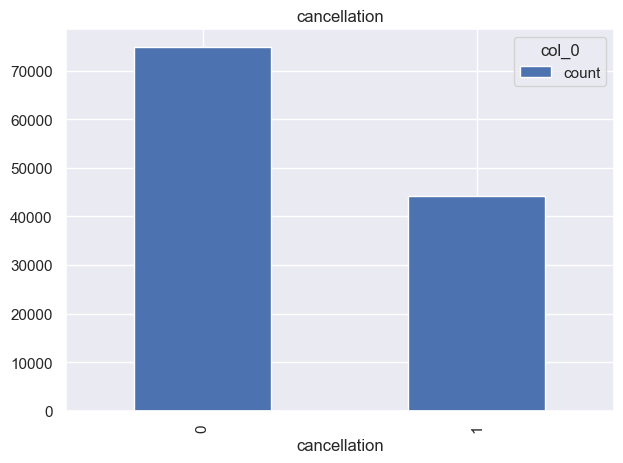

<Figure size 1000x600 with 0 Axes>

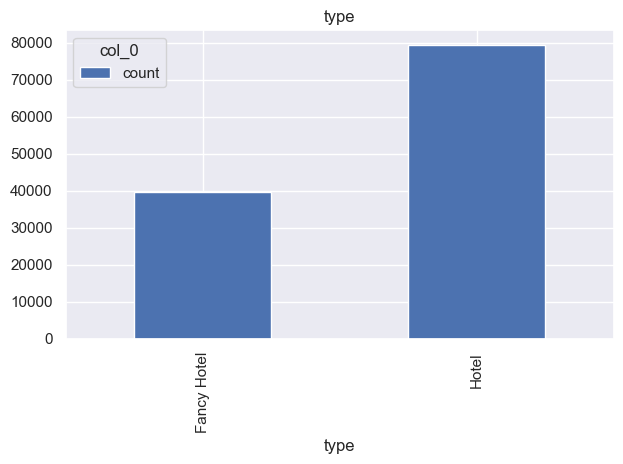

<Figure size 1000x600 with 0 Axes>

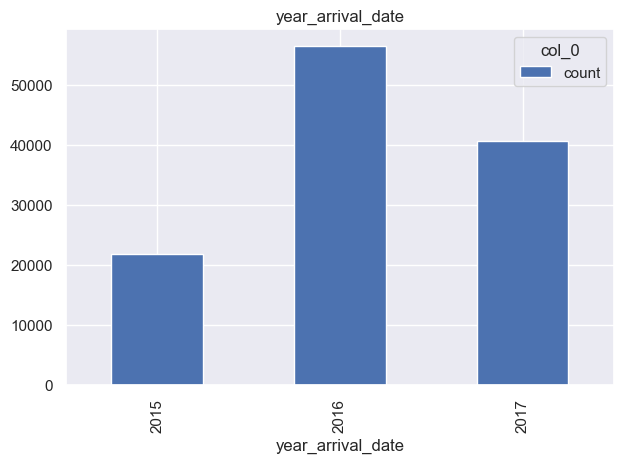

<Figure size 1000x600 with 0 Axes>

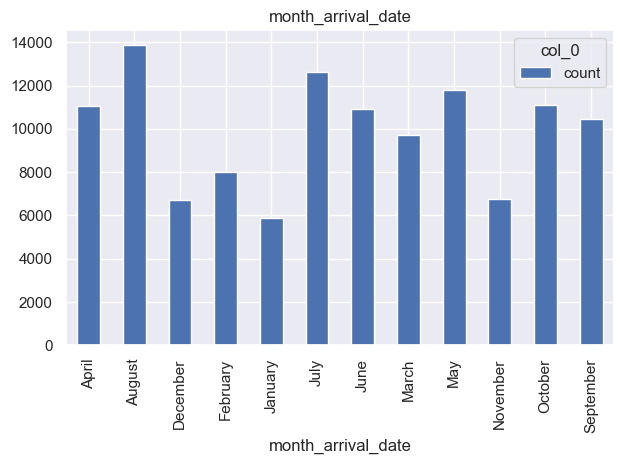

<Figure size 1000x600 with 0 Axes>

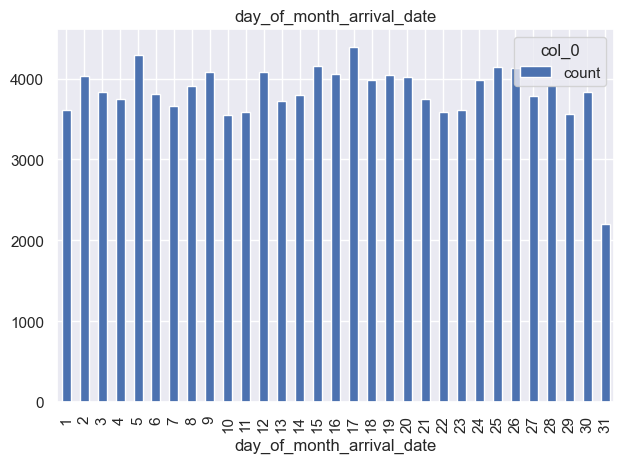

<Figure size 1000x600 with 0 Axes>

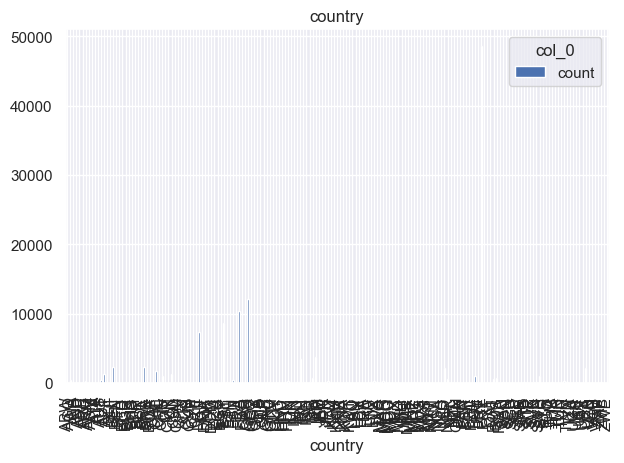

<Figure size 1000x600 with 0 Axes>

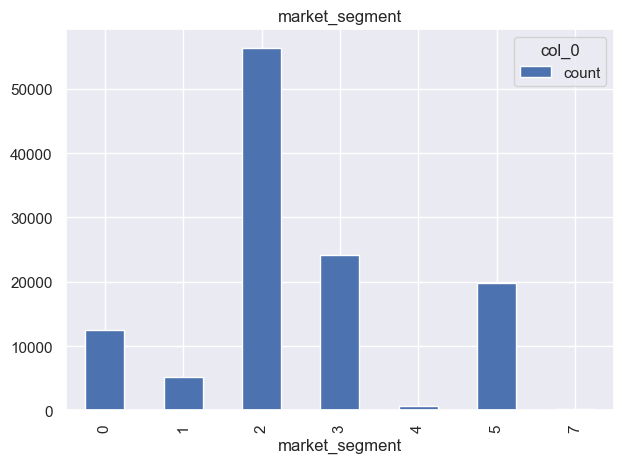

<Figure size 1000x600 with 0 Axes>

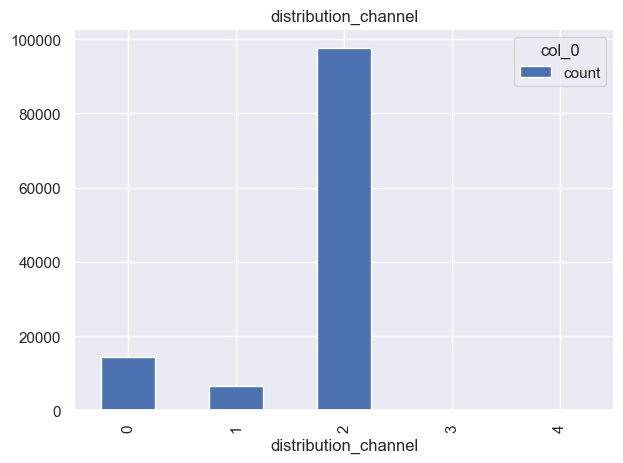

<Figure size 1000x600 with 0 Axes>

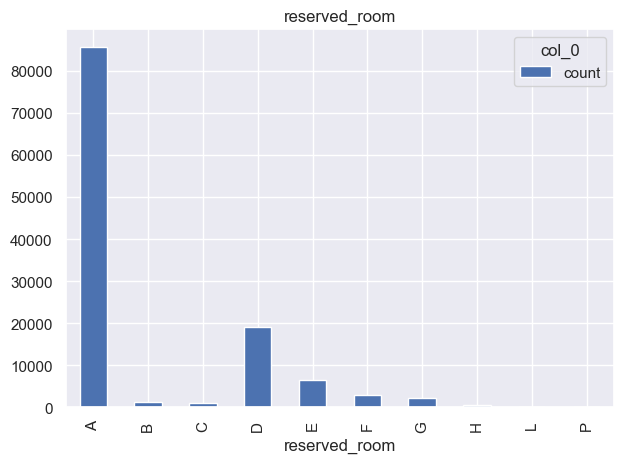

<Figure size 1000x600 with 0 Axes>

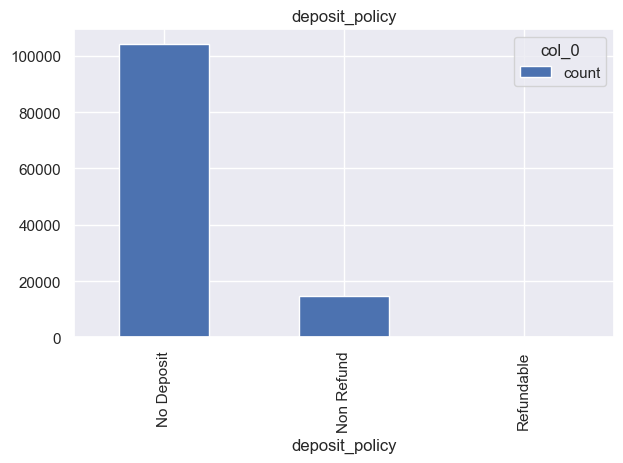

<Figure size 1000x600 with 0 Axes>

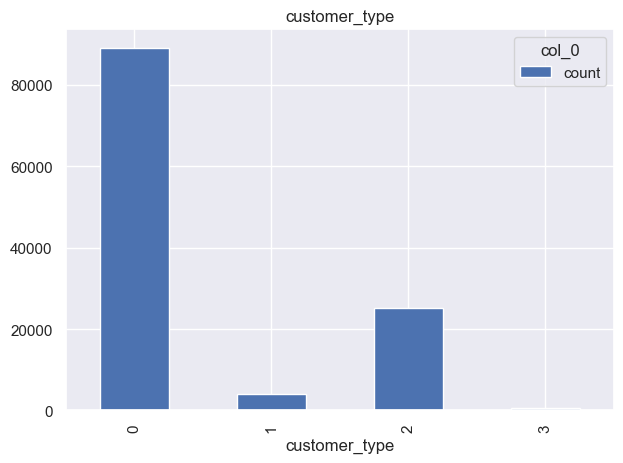

In [1361]:

for column in df_cat.columns:
    freq_table = pd.crosstab(index=df_cat[column], columns='count')


    plt.figure(figsize=(10, 6))
    freq_table.plot(kind='bar')
    plt.title(column)
    plt.tight_layout()
    plt.show();

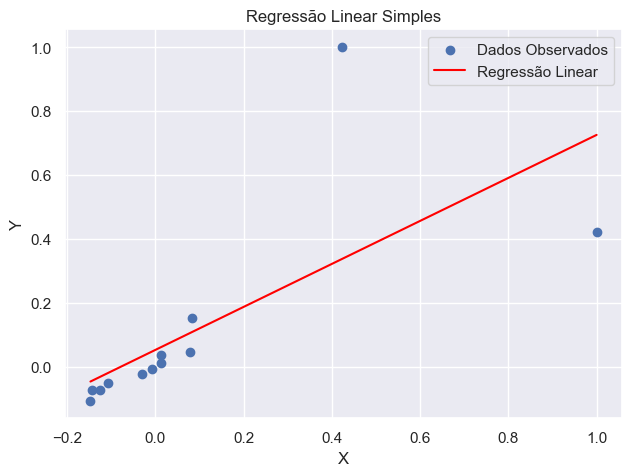

In [1364]:
# Dados de exemplo
x = np.array(correlation_matrix['repeated_guest'])
y = np.array(correlation_matrix['num_previous_stays'])

# Calculando os coeficientes da regressão linear
slope, intercept = np.polyfit(x, y, 1)

# Gerando pontos para a linha de regressão
x_regression = np.linspace(x.min(), x.max(), 100)
y_regression = slope * x_regression + intercept

# Plotando os pontos e a linha de regressão
plt.scatter(x, y, label='Dados Observados')
plt.plot(x_regression, y_regression, color='red', label='Regressão Linear')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Regressão Linear Simples')
plt.legend()
plt.show()

# Avaliar relação Preço x Reservas

In [1365]:
preco_cencellation_FancyHotel = df_meses_avg_price_FancyHotel[df_meses_avg_price_FancyHotel['cancellation']==1].groupby('month_arrival_date').sum()
preco_cencellation_Hotel = df_meses_avg_price_hotel[df_meses_avg_price_hotel['cancellation']==1].groupby('month_arrival_date').sum().groupby('month_arrival_date').sum()


Correlação entre Preço e Cancelamentos de Fancy Hotel: 0.9142114941331256
Correlação entre Preço e Cancelamentos de Hotel: 0.9831404736216289


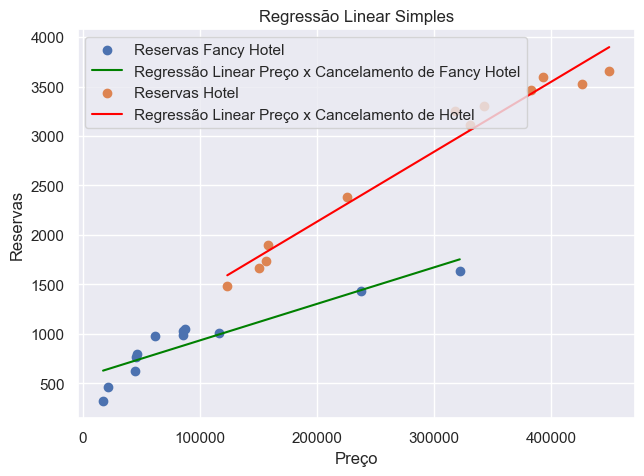

In [1366]:
# Dados de exemplo
x = np.array(preco_cencellation_FancyHotel['avg_price'])
y = np.array(preco_cencellation_FancyHotel['cancellation'])

correlation_matrix = np.corrcoef(x, y)
# Obtendo o valor da correlação entre x e y
correlation = correlation_matrix[0, 1]
print("Correlação entre Preço e Cancelamentos de Fancy Hotel:", correlation)

# Calculando os coeficientes da regressão linear
slope, intercept = np.polyfit(x, y, 1)

# Gerando pontos para a linha de regressão
x_regression = np.linspace(x.min(), x.max(), 100)
y_regression = slope * x_regression + intercept

# Plotando os pontos e a linha de regressão
plt.scatter(x, y, label='Reservas Fancy Hotel')
plt.plot(x_regression, y_regression, color='Green', label='Regressão Linear Preço x Cancelamento de Fancy Hotel')
plt.xlabel('Preço')
plt.ylabel('Reservas')
plt.title('Regressão Linear Simples')
plt.legend()

# Dados de exemplo
x = np.array(preco_cencellation_Hotel['avg_price'])
y = np.array(preco_cencellation_Hotel['cancellation'])

correlation_matrix = np.corrcoef(x, y)
# Obtendo o valor da correlação entre x e y
correlation = correlation_matrix[0, 1]
print("Correlação entre Preço e Cancelamentos de Hotel:", correlation)


# Calculando os coeficientes da regressão linear
slope, intercept = np.polyfit(x, y, 1)

# Gerando pontos para a linha de regressão
x_regression = np.linspace(x.min(), x.max(), 100)
y_regression = slope * x_regression + intercept

# Plotando os pontos e a linha de regressão
plt.scatter(x, y, label='Reservas Hotel')
plt.plot(x_regression, y_regression, color='red', label='Regressão Linear Preço x Cancelamento de Hotel')
plt.xlabel('Preço')
plt.ylabel('Reservas')
plt.title('Regressão Linear Simples')
plt.legend()

plt.show()

# 6. Pré-Processamento

### Correlação entre Variáveis Preditoras  e Variável Target

In [1362]:
correl_Target = df_num.corr()['cancellation'].abs().sort_values(ascending=False).round(4)
correl_Target

cancellation                      1.00
days_between_booking_arrival      0.29
total_of_special_requests         0.24
required_car_parking_spaces       0.19
changes_between_booking_arrival   0.14
num_previous_cancellations        0.11
repeated_guest                    0.09
num_adults                        0.06
num_previous_stays                0.06
avg_price                         0.05
num_babies                        0.03
Num_Noites                        0.02
week_number_arrival_date          0.01
Name: cancellation, dtype: float64

### Correlação entre Variáveis Preditoras

In [1363]:
correlation_matrix = df_num.iloc[:,1:].corr()

correlation_list = []

for col in correlation_matrix.columns:
    correlations = correlation_matrix[col].drop(col)
    correlation_list.extend([(col, correl_var, correlation) for correl_var, correlation in correlations.iteritems()])

# Exibir a lista de correlação
correl_List = []
for correlation in correlation_list:
    correl_List.append(correlation)
correl_Predict = pd.DataFrame(correl_List)
correl_Predict = correl_Predict.rename(columns={0:'Var_A',1:'Var_B',2:'Correlaccao'})
correl_Predict.sort_values('Correlaccao', ascending=False).head(80)

,Var_A,Var_B,Correlaccao
49,repeated_guest,num_previous_stays,0.42
70,num_previous_stays,repeated_guest,0.42
29,num_adults,avg_price,0.24
90,avg_price,num_adults,0.24
118,total_of_special_requests,avg_price,0.18
97,avg_price,total_of_special_requests,0.18
121,Num_Noites,days_between_booking_arrival,0.16
10,days_between_booking_arrival,Num_Noites,0.16
71,num_previous_stays,num_previous_cancellations,0.15
60,num_previous_cancellations,num_previous_stays,0.15


# Separar Variáveis

In [1367]:
df_num = df[dfnumerica]
df_cat = df[dfcategorica]

In [1368]:
dropcat = ['year_arrival_date','month_arrival_date','day_of_month_arrival_date']
#dropcat = ['country']
df_cat = df_cat.drop(dropcat, axis=1)

In [1369]:
'''from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_cat = df_cat.apply(label_encoder.fit_transform)
df_cat.head(2)'''

'from sklearn.preprocessing import LabelEncoder\n\nlabel_encoder = LabelEncoder()\ndf_cat = df_cat.apply(label_encoder.fit_transform)\ndf_cat.head(2)'

In [1370]:
# dummizando os dados de treino e teste 
df_cat = pd.get_dummies(df_cat)
df_cat.head(2)

,type_Fancy Hotel,type_Hotel,country_ABW,country_AGO,country_AIA,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,...,reserved_room_B,reserved_room_C,reserved_room_D,reserved_room_E,reserved_room_F,reserved_room_G,reserved_room_H,reserved_room_L,reserved_room_P,deposit_policy_No Deposit,deposit_policy_Non Refund,deposit_policy_Refundable,customer_type_0,customer_type_1,customer_type_2,customer_type_3
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0


# Avaliar Relevância das Variáveis Numéricas

In [1371]:
df_ = pd.concat([df_num,df_cat], axis=1)
y=df_.cancellation
x=df_.drop(['cancellation'], axis=1)
x.shape,y.shape

((118898, 220), (118898,))

In [1372]:
model = ExtraTreesClassifier(n_estimators=10)
model.fit(x, y)

ExtraTreesClassifier(n_estimators=10)

<Axes: >

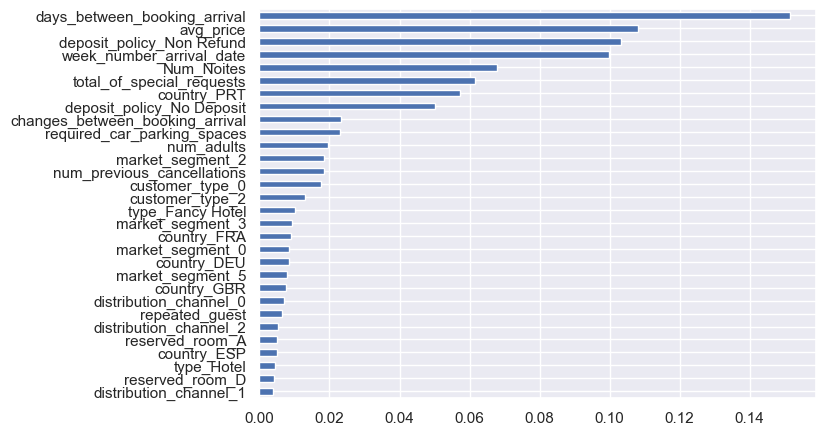

In [1373]:
(pd.Series(model.feature_importances_, index=x.columns)
   .nlargest(30).sort_values().plot.barh())

In [1374]:
# Escolher Variaveis 
xnew = x.iloc[:,:]

In [1375]:
# Normalizar  Dados
scaler = MinMaxScaler()
xnew = scaler.fit_transform(xnew)

In [1376]:
# Dividir Data Frame Em Treino E Test
x_train, x_val, y_train, y_val = train_test_split(xnew, y, test_size=0.3, random_state=0)

# 7. Criação da Maquina Preditiva

In [1377]:
# Logistic Regression
logreg=LogisticRegression().fit(x_train,y_train)
logreg

# GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(x_train, y_train)

#  LightGBM Classifier
lgb_model = lgb.LGBMClassifier(learning_rate = 0.001, 
                              num_leaves = 65,  
                              n_estimators = 100)                       
lgb_model.fit(x_train, y_train)
 
# XGBoost
xgb_model = xgb.XGBClassifier(learning_rate=0.001,
                            max_depth = 1, 
                            n_estimators = 100)
xgb_model.fit(x_train, y_train)

# AdaBoost
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=100,
    algorithm="SAMME.R", learning_rate=0.001)
ada_clf.fit(x_train, y_train)

print('*****************ClassifiersDone*****************')

*****************ClassifiersDone*****************


# 9. Avaliação dos Resultados

In [1378]:
models=['Logistic','GradientBoost','LightGBM','XGBoost','AdaBoost']

Trainning_Accuracy=[logreg.score(x_train,y_train),
                    gbrt.score(x_train, y_train),
                    lgb_model.score(x_train, y_train),
                    xgb_model.score(x_train, y_train), 
                    ada_clf.score(x_train, y_train)]

Validation_Accuracy=[logreg.score(x_val, y_val),
                    gbrt.score(x_val, y_val),
                    lgb_model.score(x_val, y_val),
                    xgb_model.score(x_val, y_val), 
                    ada_clf.score(x_val, y_val)]

pd.DataFrame(list(zip(Trainning_Accuracy, Validation_Accuracy)), 
                  columns =['Trainning_Accuracy', 'Validation_Accuracy'],
                  index=models)

,Trainning_Accuracy,Validation_Accuracy
Logistic,0.81,0.80
GradientBoost,0.84,0.83
LightGBM,0.63,0.63
XGBoost,0.75,0.75
AdaBoost,0.75,0.75


# Avaliação do Modelo De Melhor Performance

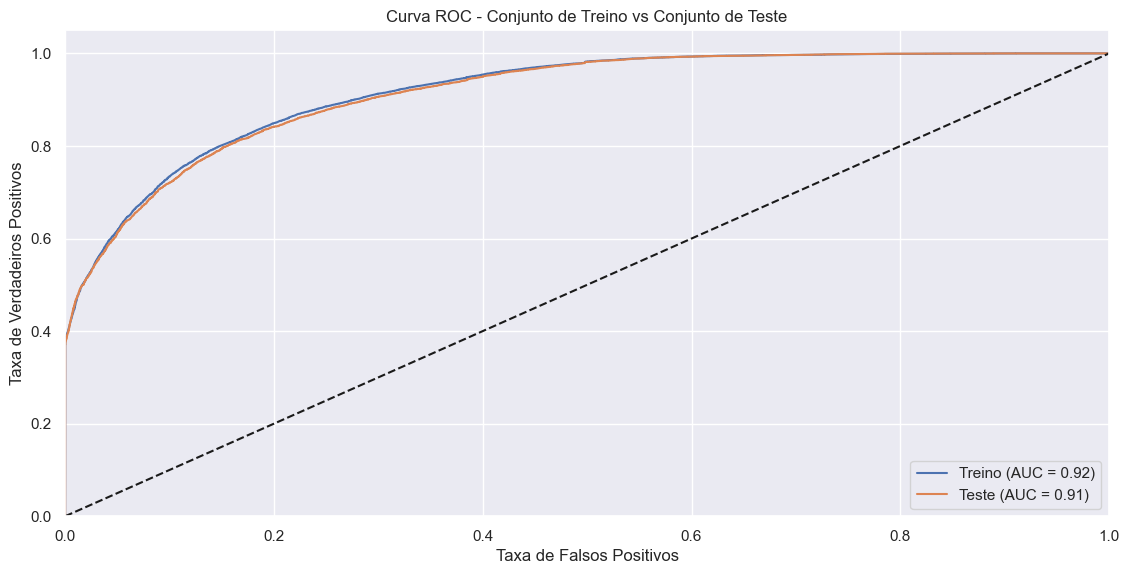

In [1379]:
# Calculando a probabilidade das classes positivas para os conjuntos de treino e teste
y_train_pred_proba = gbrt.predict_proba(x_train)[:, 1]
y_test_pred_proba = gbrt.predict_proba(x_val)[:, 1]

# Calculando a taxa de falsos positivos, taxa de verdadeiros positivos e limiares para os conjuntos de treino e teste
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, thresholds_test = roc_curve(y_val, y_test_pred_proba)

# Calculando a área sob a curva ROC (ROC AUC) para os conjuntos de treino e teste
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
roc_auc_test = roc_auc_score(y_val, y_test_pred_proba)

# Plotando as curvas ROC para os conjuntos de treino e teste
plt.figure(figsize=(12, 6))
plt.plot(fpr_train, tpr_train, label='Treino (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, label='Teste (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], 'k--')  # Linha pontilhada representando o desempenho aleatório
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Conjunto de Treino vs Conjunto de Teste')
plt.legend(loc="lower right")
plt.show()


# Cross Validation (K-Fold)

In [1380]:
df_num = df[dfnumerica]
df_cat = df[dfcategorica]

dropcat = ['year_arrival_date','month_arrival_date','day_of_month_arrival_date']
#dropcat = ['country']
df_cat = df_cat.drop(dropcat, axis=1)

# dummizando os dados de treino e teste 
df_cat = pd.get_dummies(df_cat)
df_cat.head(2)

df_ = pd.concat([df_num,df_cat], axis=1)
y=df_.cancellation
x=df_.drop(['cancellation'], axis=1)
x.shape,y.shape

# Escolher Variaveis 
xnew = x.iloc[:,:]

# Normalizar  Dados
scaler = MinMaxScaler()
xnew = scaler.fit_transform(xnew)

In [1381]:
# Defina o modelo
gbrt = GradientBoostingClassifier(random_state=0)

# Realize a validação cruzada com K-Fold (por exemplo, K = 5)
k = 4
scores = cross_val_score(gbrt, xnew, y, cv=k, scoring='accuracy')

# Imprima as métricas obtidas em cada fold e a média
print("Acurácia em cada fold:", scores)
print("Acurácia média:", scores.mean())

Acurácia em cada fold: [0.65110177 0.74506308 0.75952093 0.77190149]
Acurácia média: 0.7318968160001648


# CrossValidation Série Temporal

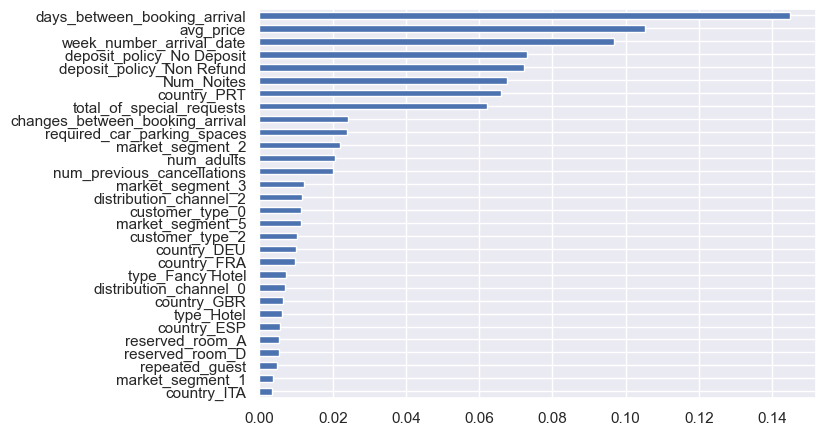

In [1263]:
# dummizando os dados de treino e teste 
df_cat = pd.get_dummies(df_cat)

df_ = pd.concat([df_num,df_cat], axis=1)
y=df_.cancellation
x=df_.drop(['cancellation'], axis=1)
x.shape,y.shape

model = ExtraTreesClassifier(n_estimators=10)
model.fit(x, y)

(pd.Series(model.feature_importances_, index=x.columns)
   .nlargest(30).sort_values().plot.barh())

# Escolher Variaveis 
xnew = x.iloc[:,:]

# Normalizar  Dados
scaler = MinMaxScaler()
xnew = scaler.fit_transform(xnew)

In [1382]:
# Definir o modelo
gbrt = GradientBoostingClassifier(random_state=0)

# Criar objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Realizar a validação cruzada temporal com cross_val_score
scores = cross_val_score(gbrt, xnew, y, cv=tscv, scoring='accuracy')

# Imprimir as métricas obtidas em cada fold e a média
print("Acurácia em cada fold:", scores)
print("Acurácia média:", scores.mean())


Acurácia em cada fold: [0.62086193 0.70877069 0.93565805 0.4655329  0.64987889]
Acurácia média: 0.6761404925312879


# Respostas

### Comece respondendo as seguintes questões:
    
    a) Elabore hipóteses e visualizações envolvendo a variável cancellation e, pelo menos, outras duas variáveis 
    presentes no dataset;

    b) Desenvolva um modelo preditivo de classificação para identificar cancelamentos e utilize métricas adequadas 
    para argumentar a efetividade do modelo;

    c) Ao realizar a validação cruzada do modelo de classificação, discuta sobre as diferenças entre utilizar uma separação
    entre treino e teste aleatória e uma separação temporal (Ex: treino em 2015 e 2016 e validação em 2017). 
    Os resultados são diferentes? Qual o mais indicado?

    A) Hipótese 1 - Os preços oscilam ao longo dos meses
       Hipótese 2 - Os cancelamentos aumentam conforme aumento dos preços
       Hipótese 3 - Há sazonalidade no número de reservas
       Variáveis analisadas, preços, cancelamentos, reservas, reservas confirmadas, reservas canceladas, mês, 
       
       Hipótese 1 CONFIRMADA.
       os preços oscilam ao longo do ano, entretanto, as oscilações são maiores em Fancy Hotel.
       
       Hipótese 2 CONFIRMADA.
       Na hospedagem tipo Hotel, essa relação é mais acentuada
       Observação:
       Os cancelamentos e reservas aumentam conforme os preços se elevam.
       
       Hipótese 3 Parcialmente CONFIRMADA. 
       Na hospedagem tipo Hotel, o volume de hospedagem possui menor oscilação.
       Na hospedagem tipo Fancy Hotel, as reservas aumentam consideravelmente na metade do ano.       
       
    B) O Modelo que apresentou melhor resultado foi desenvolvido utilizando o algoritmo GradientBoost.
       Utilizei principalmente a Acurácia para avaliar o modelo, pois é a métrica mais simples e direta, que mede a
       proporção de amostras classificadas corretamente pelo modelo e também a curva Roc para avaliar e visualizar o 
       desempenho de modelos 
    
    c) Verificamos que a dinâmica de preços, reservas e cancelamentos, possui comportamento sazonal.
       Sendo assim, a distribuição dos dados oscila no decorrer dos meses.
       Por essa razão, realizar divisão temporal de dados, pode ser menos eficiente, pois restringir a amostragem dos dados 
       para períodos específicos, podem não captar com eficiência essas variações.
    
       Também foi verificado, que a utilização do método de CrossValidation, reduziu a acurácia do modelo. Possivelmente, 
       ao utilizar um conjunto de dados menor, o modelo captou as oscilações com menor eficiência.
    
       Utilizar divisão temporal de dados, apresentou menor eficiência no modelo testado, acredito que por avaliarmos.
       OBS: Essas conclusoes foram baseadas nos resultados obtidos com o algoritmo K-Fold.